## 第一部分 数据EDA
### 对于时间序列数据的EDA，一般可以从以下几方面着手：
* 数据集的整体体量
* 是否有缺失值、异常值等脏数据
* 数据的趋势性特征
* 数据的分布情况

In [1]:
# 导入工具包
import numpy as np  # linear algebra
import pandas as pd  #
from datetime import datetime, date, timedelta
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV,Ridge,Lasso,ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.svm import SVR, LinearSVC
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
from itertools import product
import datetime as dt
import calendar
import gc

RANDOM_SEED = 42
# 引入中文字体
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname="./NotoSansCJKsc-Light.otf", size=12)

In [19]:
# 数据集加载
train = pd.read_csv('./train.csv')
# 把测试集的id列作为索引，防止误删
test  = pd.read_csv('./submission.csv').set_index('customer_id')

In [3]:
# 对于特别大的文件，我们需要做一些内存检查
mem_train = train.memory_usage(index=True).sum()
mem_test=test.memory_usage(index=True).sum()
print(u"训练集使用内容 "+ str(round((mem_train/ 1024**2),2))+" MB")
print(u"测试集使用内存 "+ str(round((mem_test/ 1024**2),2))+" MB")

训练集使用内容 510.4 MB
测试集使用内存 24.2 MB


### 训练集文件
* order_detail_id 订单详情id
* order_id 订单id
* order_total_num 订单商品总购买数量
* order_amount 订单商品总金额
* order_total_payment 订单实付金额
* order_total_discount 订单优惠金额
* order_pay_time 付款时间
* order_status 订单状态： 1表示等待买家付款， 2表示卖家部分发货， 3表示卖家发货， 4表示等待买家确认收货， 5表示买家已签收， 6表示交易成功
* order_count 订单包含的子订单数量
* is_customer_rate 用户是否评价，0没有评价，1已经评价
* order_detail_status 订单详细状态
* order_detail_goods_num 订单中的商品数量
* order_detail_amount 订单应付总金额
* order_detail_payment 订单实付金额
* order_detail_discount 订单优惠金额
* member_id 会员id
* customer_id 用户id
* customer_gender 性别：0未知，1男，2女
* customer_province 用户省份所在地
* customer_city 用户城市所在地
* member_status 会员状态：1正常，2冻结，3已删除
* is_member_actived 会员是否激活：0没有激活，1已激活
* goods_id 商品id
* goods_class_id 商品分类id
* goods_price 商品原始价格
* goods_status 商品库存状态：1出售中，2库中
* goods_has_discount 是否支持会员折扣：0不支持，1支持
* goods_list_time 商品最新上架时间
* goods_delist_time 商品最新下架时间
### 提交文件
* customer_id 用户id
* result 下个月是否会购买：0 不购买，1购买

In [4]:
# 分类型按列的数据分布与异常值统计

def summary_stats_table(data):
    # 空值数量
    missing_counts = pd.DataFrame(data.isnull().sum())
    missing_counts.columns = ['count_null']

    # numeric column stats
    # 数值列数据分布统计
    num_stats = data.select_dtypes(include=['int64','float64']).describe().loc[['count','min','mean','max','25%','50%','75%']].transpose()
    num_stats['dtype'] = data.select_dtypes(include=['int64','float64']).dtypes.tolist()

    # non-numeric value stats
    # 非数值列数据分布统计
    non_num_stats = data.select_dtypes(exclude=['int64','float64']).describe().transpose()
    non_num_stats['dtype'] = data.select_dtypes(exclude=['int64','float64']).dtypes.tolist()
    non_num_stats = non_num_stats.rename(columns={"first": "min", "second": "mean", "last": "max"})

    # merge all 
    # 聚合结果
    stats_merge = pd.concat([num_stats, non_num_stats], axis=0, join='outer', ignore_index=False, keys=None,
              levels=None, names=None, verify_integrity=False, copy=True, sort=False).fillna("").sort_values('dtype')

    column_order = ['dtype', 'count', 'count_null','unique','min','mean','max','25%','50%','75%','top','freq']
    summary_stats = pd.merge(stats_merge, missing_counts, left_index=True, right_index=True, sort=False)[column_order]
    return(summary_stats)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306871 entries, 0 to 2306870
Data columns (total 29 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_detail_id         int64  
 1   order_id                int64  
 2   order_total_num         float64
 3   order_amount            float64
 4   order_total_payment     float64
 5   order_total_discount    float64
 6   order_pay_time          object 
 7   order_status            int64  
 8   order_count             float64
 9   is_customer_rate        float64
 10  order_detail_status     float64
 11  order_detail_goods_num  float64
 12  order_detail_amount     float64
 13  order_detail_payment    float64
 14  order_detail_discount   float64
 15  customer_province       object 
 16  customer_city           object 
 17  member_id               float64
 18  customer_id             int64  
 19  customer_gender         float64
 20  member_status           float64
 21  is_member_actived       float64

In [6]:
summary_stats_table(train)

,dtype,count,count_null,unique,min,mean,max,25%,50%,75%,top,freq
order_detail_id,int64,2306871.0,0,,1e+06,2.34004e+06,3.6855e+06,1.66968e+06,2.33935e+06,3.00743e+06,,
order_id,int64,2306871.0,0,,1e+06,2.13615e+06,3.23836e+06,1.57148e+06,2.14299e+06,2.70795e+06,,
goods_class_id,int64,2306871.0,0,,998,1558.21,6673,1038,1233,1643,,
order_status,int64,2306871.0,0,,0,9.85862,101,6,6,6,,
goods_id,int64,2306871.0,0,,998,1558.21,6673,1038,1233,1643,,
customer_id,int64,2306871.0,0,,1e+06,1.93323e+06,2.82657e+06,1.43643e+06,1.92957e+06,2.45782e+06,,
goods_has_discount,float64,2306871.0,0,,0,0.0861362,1,0,0,0,,
goods_status,float64,2306871.0,0,,0,1.09171,2,1,1,1,,
goods_price,float64,2306435.0,436,,-79.9748,52.1955,92.3526,49.6004,53.9093,54.8506,,
is_member_actived,float64,635790.0,1671081,,1,1,1,1,1,1,,


* 通过上面的统计发现商品原始价格goods_price出现了负数而订单优惠折扣order_detail_discount出现了正数的情况
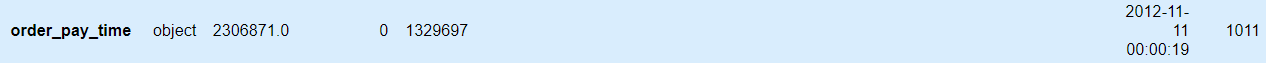
* 双十一的影响在order_pay_time上反映也非常明显

In [7]:
train[train['order_status']>6]['order_status'].count()

98145

In [8]:
train[train.order_status>6].head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
18,1001547,1001340,2.0,339.8,89.9,0.0,2013-08-31 15:13:04,101,2.0,0.0,...,NaN,NaN,NaN,998,998,54.836807,1.0,0.0,2014-10-25 11:08:07,2014-11-01 11:08:07
19,1001548,1001340,2.0,339.8,89.9,0.0,2013-08-31 15:13:04,101,2.0,0.0,...,NaN,NaN,NaN,1958,1958,46.118263,2.0,0.0,2013-09-21 08:58:00,2013-09-27 17:37:59
20,1001549,1001341,1.0,239.9,89.9,0.0,2013-08-31 15:00:04,101,1.0,0.0,...,NaN,NaN,NaN,998,998,54.810267,1.0,0.0,2014-10-25 11:08:07,2014-11-01 11:08:07
73,1001602,1001374,2.0,298.9,39.9,0.0,2013-08-30 10:08:38,101,2.0,0.0,...,NaN,NaN,NaN,1983,1983,53.037544,1.0,1.0,2014-10-28 14:31:17,2014-11-04 14:31:17
74,1001603,1001374,2.0,298.9,39.9,0.0,2013-08-30 10:08:38,101,2.0,0.0,...,NaN,NaN,NaN,1468,1468,46.181811,0.0,1.0,2014-04-18 11:00:22,2014-04-18 17:00:38


* 订单状态order_status最大值101，不在赛题说明中，但是有98145条记录，怀疑是交易失败等异常情况

#### 内存优化脚本
参考缓解pandas中DataFrame占用内存过大的问题<br/>
https://blog.csdn.net/wj1066/article/details/81124959<br/>
效果非常显著，有效避免内存溢出<br/>
* 可以考虑的优化步骤包括<br/>
查询列的数值范围<br/>
给每一列选择合适的数值类型<br/>
修改数值类型<br/>
把日期列切成年月日3列(默认的datatime会比较占空间)<br/>
填充NaN

In [20]:
# 处理id字段
train['order_detail_id'] = train['order_detail_id'].astype(np.uint32)
train['order_id'] = train['order_id'].astype(np.uint32)
train['customer_id'] = train['customer_id'].astype(np.uint32)
train['goods_id'] = train['goods_id'].astype(np.uint32)
train['goods_class_id'] = train['goods_class_id'].astype(np.uint32)
train['member_id'] = train['member_id'].astype(np.uint32)
# 处理状态字段，这里同时处理空值，将空值置为0
train['order_status'] = train['order_status'].astype(np.uint8)
train['goods_has_discount'] = train['goods_has_discount'].astype(np.uint8)
train["is_member_actived"].fillna(0, inplace=True)
train["is_member_actived"]=train["is_member_actived"].astype(np.int8)
train["member_status"].fillna(0, inplace=True)
train["member_status"]=train["member_status"].astype(np.int8)
train["customer_gender"].fillna(0, inplace=True)
train["customer_gender"]=train["customer_gender"].astype(np.int8)
train['is_customer_rate'] = train['is_customer_rate'].astype(np.uint8)
train['order_detail_status'] = train['order_detail_status'].astype(np.uint8)
# 处理日期
train['goods_list_time']=pd.to_datetime(train['goods_list_time'],format="%Y-%m-%d")
train['order_pay_time']=pd.to_datetime(train['order_pay_time'],format="%Y-%m-%d")
train['goods_delist_time']=pd.to_datetime(train['goods_delist_time'],format="%Y-%m-%d")
# 检查内存使用
mem_train = train.memory_usage(index=True).sum()
mem_test=test.memory_usage(index=True).sum()
print(u"训练集使用内容 "+ str(mem_train/ 1024**2)+" MB")
print(u"测试集使用内存 "+ str(mem_test/ 1024**2)+" MB")

训练集使用内容 349.8006982803345 MB
测试集使用内存 24.200225830078125 MB


#### 商品原始价格分析

C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


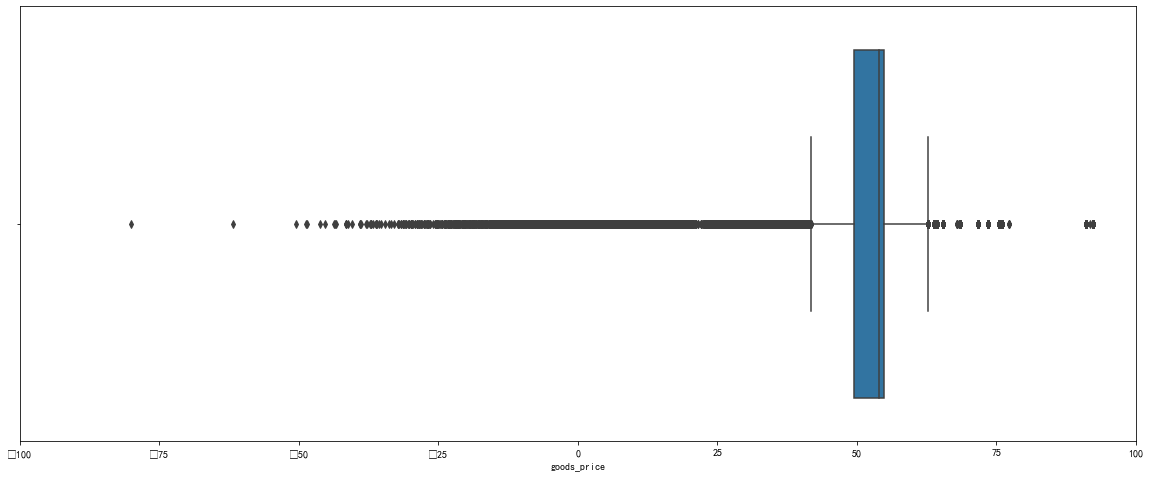

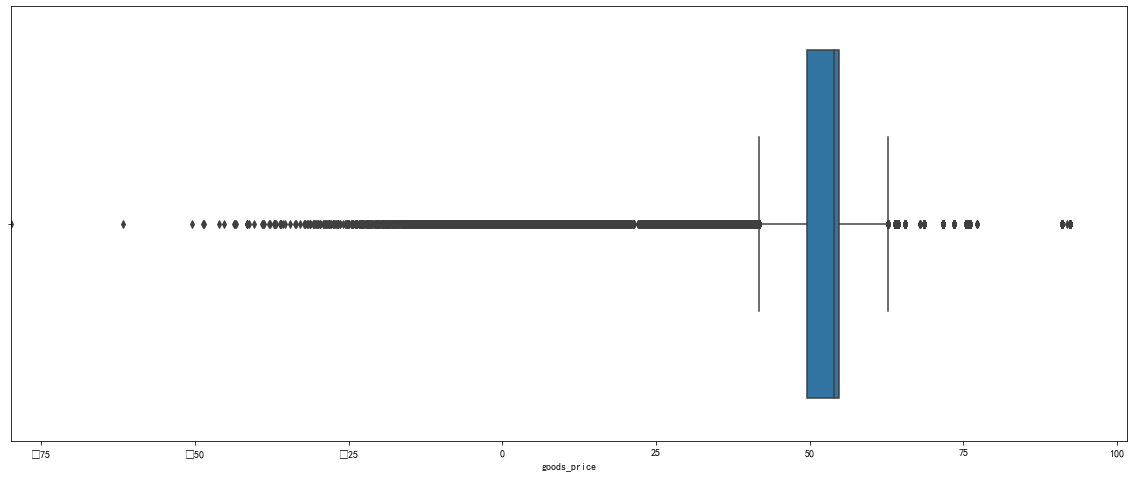

In [10]:
plt.figure(figsize=(20,8))
# x轴坐标范围
plt.xlim(-100, 100)
sns.boxplot(x=train.goods_price)

plt.figure(figsize=(20,8))
# x轴坐标范围
plt.xlim(train.goods_price.min(), train.goods_price.max()*1.1)
sns.boxplot(x=train.goods_price)

In [11]:
train[train.goods_price<0].head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
2312,1003841,1003239,1.0,0.01,0.01,0.0,2013-05-12 20:21:07,6,1.0,0,...,0,0,0,2538,2538,-12.965136,1.0,0,2014-10-28 09:43:51,2014-11-04 09:43:51
2523,1004052,1003440,1.0,0.01,0.01,0.0,2013-04-22 10:22:39,6,1.0,0,...,0,0,0,2538,2538,-9.717323,1.0,0,2014-10-28 09:43:51,2014-11-04 09:43:51
2822,1004351,1003720,23.0,23.00,23.00,0.0,2013-04-03 21:40:50,6,1.0,0,...,0,0,0,1768,1768,-0.334533,1.0,0,2014-10-28 11:30:18,2014-11-04 11:30:18
5203,1006732,1005821,1.0,1.00,1.00,0.0,2013-01-24 22:00:31,6,1.0,0,...,0,0,0,3098,3098,-16.420158,2.0,0,2014-01-10 15:47:52,2014-01-11 12:46:23
6193,1007722,1006556,1.0,1.00,1.00,0.0,2013-01-09 14:13:06,6,1.0,0,...,0,0,0,3278,3278,-7.076659,2.0,0,2013-01-09 14:00:00,2013-01-09 14:00:06


In [12]:
# 找出商品加个为负的商品id
train[train.goods_price<0]['goods_id'].unique()

array([2538, 1768, 3098, 3278, 3673, 3678, 3713, 3643, 4533, 3203, 4288,
       4503, 4548, 4078, 3213, 5403, 4303, 3743, 4603, 4228, 5978, 5023,
       5333, 2423, 3633, 5298, 4423], dtype=uint32)

In [13]:
train[train.goods_price<0].describe()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_status,order_count,is_customer_rate,order_detail_status,...,member_id,customer_id,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount
count,2.145000e+03,2.145000e+03,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,...,2.145000e+03,2.145000e+03,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000
mean,2.427156e+06,2.208919e+06,9.930070,28.348065,15.332737,0.057352,7.377622,1.087646,0.063869,7.421911,...,6.714673e+05,1.903100e+06,0.031702,0.334266,0.334266,3263.512821,3263.512821,-7.074918,1.550117,0.020513
std,7.859949e+05,6.592681e+05,48.088264,105.575971,57.467282,1.022187,12.087795,0.455851,0.244577,12.255618,...,1.105172e+06,6.033998e+05,0.220079,0.471843,0.471843,853.998862,853.998862,7.931055,0.572562,0.141779
min,1.003841e+06,1.003239e+06,1.000000,0.010000,0.010000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000e+00,1.001797e+06,0.000000,0.000000,0.000000,1768.000000,1768.000000,-79.974788,0.000000,0.000000
25%,1.747607e+06,1.638063e+06,1.000000,1.000000,1.000000,0.000000,6.000000,1.000000,0.000000,6.000000,...,0.000000e+00,1.334070e+06,0.000000,0.000000,0.000000,2538.000000,2538.000000,-9.298503,1.000000,0.000000
50%,2.489982e+06,2.271528e+06,1.000000,1.000000,1.000000,0.000000,6.000000,1.000000,0.000000,6.000000,...,0.000000e+00,1.836902e+06,0.000000,0.000000,0.000000,3643.000000,3643.000000,-4.475426,2.000000,0.000000
75%,3.122906e+06,2.798192e+06,1.000000,1.000000,1.000000,0.000000,6.000000,1.000000,0.000000,6.000000,...,1.245740e+06,2.520899e+06,0.000000,1.000000,1.000000,3678.000000,3678.000000,-1.805521,2.000000,0.000000
max,3.685398e+06,3.238287e+06,1690.000000,1690.000000,1690.000000,32.380000,101.000000,8.000000,1.000000,101.000000,...,4.117926e+06,2.826523e+06,2.000000,1.000000,1.000000,5978.000000,5978.000000,-0.002368,2.000000,1.000000


In [14]:
train[train.goods_id==3098].head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
4595,1006124,1005323,1.0,1.0,1.0,0.0,2013-01-28 23:01:23,6,1.0,0,...,0,0,0,3098,3098,6.200496,2.0,0,2014-01-10 15:47:52,2014-01-11 12:46:23
5203,1006732,1005821,1.0,1.0,1.0,0.0,2013-01-24 22:00:31,6,1.0,0,...,0,0,0,3098,3098,-16.420158,2.0,0,2014-01-10 15:47:52,2014-01-11 12:46:23
14134,1017231,1014834,1.0,1.0,1.0,0.0,2013-01-28 23:01:01,6,1.0,0,...,0,0,0,3098,3098,-4.398973,2.0,0,2014-01-10 15:47:52,2014-01-11 12:46:23
23704,1028271,1024252,1.0,1.0,1.0,0.0,2013-01-28 23:01:02,6,1.0,0,...,0,0,0,3098,3098,9.244595,2.0,0,2014-01-10 15:47:52,2014-01-11 12:46:23
33430,1039528,1033850,1.0,1.0,1.0,0.0,2013-01-28 23:01:56,6,1.0,0,...,0,0,0,3098,3098,-29.069258,2.0,0,2014-01-10 15:47:52,2014-01-11 12:46:23


* 从图中可以看出负值价格的商品情况还是比较多的，但这里有个非常奇怪的情况，这些负值商品涉及的订单并没有折扣标记。难道是买二送一？或者优惠券？
* 进一步分析发现，这些负值价格的商品流水记录尽管有2581条，对应只有26个商品id，集中度非常高
* 有可能是默认的赠品？<br/>
* 也可能是类似“一元/分钱抢XXX”活动的商品
* 还有可能是活动商品
* 这里引发了一个怀疑，商品价格是不是真的商品价格？有电商购物经验时我们会知道，有时优惠券抵扣的价格会以比较奇怪的形式（可能是按比例）分摊在每个商品上，如果是这样的话，那么这里商品价格的特征要附加是否有优惠券抵扣？不清楚业务规则的情况下，商品价格的特征处理比较麻烦。

#### 订单优惠折扣分析
这块数据就更奇怪了，感觉goods_has_discount这个字段反映的根本不是折扣的真实情况，诸如类似一元抢购和绝大多数折扣的场景根本没有识别出来

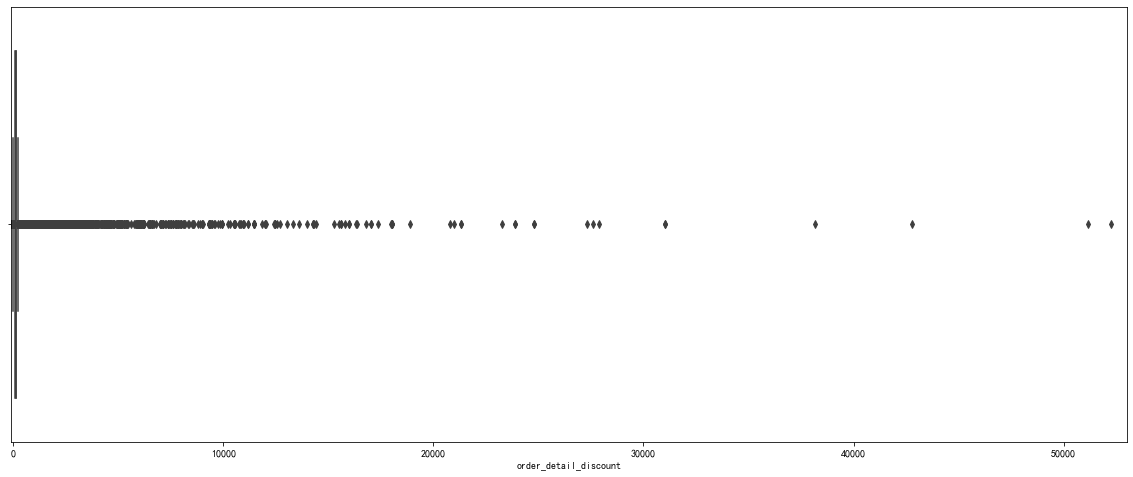

In [15]:
plt.figure(figsize=(20,8))
# x轴坐标范围
plt.xlim(-120, 53000)
sns.boxplot(x=train.order_detail_discount)

# plt.figure(figsize=(20,8))
# # x轴坐标范围
# plt.xlim(b.order_detail_discount.min(), b.order_detail_discount.max()*1.1)
# sns.boxplot(x=b.order_detail_discount)

In [16]:
train[train.order_detail_discount>70000].head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
1376878,2598479,2364075,256.0,102374.0,22984.4,30.0,2013-01-25 15:26:09,3,1.0,0,...,0,0,0,4473,4473,59.945033,2.0,0,2013-02-19 11:57:38,2013-02-24 10:47:56


In [17]:
train[train.order_detail_discount<0].head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
9313,1010842,1009334,2.0,545.8,465.8,50.0,2012-11-11 08:24:57,6,1.0,0,...,0,0,0,3733,3733,63.994268,2.0,0,2012-11-06 15:53:21,2012-11-11 01:41:31
9328,1010857,1009349,1.0,120.5,85.5,25.0,2012-11-11 09:15:22,6,1.0,0,...,0,0,0,3008,3008,55.232862,1.0,0,2014-10-24 16:30:39,2014-10-31 16:30:39
9346,1010875,1009367,1.0,120.5,85.5,25.0,2012-11-11 01:01:09,6,1.0,0,...,0,0,0,3008,3008,55.243978,1.0,0,2014-10-24 16:30:39,2014-10-31 16:30:39
9362,1010891,1009383,1.0,120.5,85.5,25.0,2012-11-11 01:02:18,6,1.0,0,...,0,0,0,3008,3008,55.197161,1.0,0,2014-10-24 16:30:39,2014-10-31 16:30:39
9365,1010894,1009386,1.0,116.4,86.4,20.0,2012-11-11 01:03:33,6,1.0,0,...,0,0,0,1858,1858,56.777319,1.0,0,2014-10-24 23:59:59,2014-10-31 23:59:59


#### 中文id映射
有一些字段是中文，在服务器上不好显示，这里先做ID映射

In [21]:
train['customer_city_id'] = LabelEncoder().fit_transform(train['customer_city'].astype(str))
train['customer_province_id'] = LabelEncoder().fit_transform(train['customer_province'].astype(str))

In [19]:
train[['customer_city_id','customer_province_id']]

,customer_city_id,customer_province_id
0,53,4
1,322,3
2,322,3
3,185,20
4,53,4
...,...,...
2306866,176,12
2306867,334,9
2306868,334,9
2306869,334,9


#### 日期处理
* 下单日期就以付款时间为准
* 商品的上架和下架时间比较难处理，但是还是需要
* 如果商品下架，预测销量应该直接为0

In [20]:

# 处理日期
# train['order_pay_time']=pd.to_datetime(train['order_pay_time'],format="%Y-%m-%d")
# 增加年月日时间字段
train['Year'] = pd.DatetimeIndex(train['order_pay_time']).year
train['Month'] = pd.DatetimeIndex(train['order_pay_time']).month
train['Day'] =pd.DatetimeIndex(train['order_pay_time']).day.astype(np.uint8)
train['Hour'] =pd.DatetimeIndex(train['order_pay_time']).hour

In [21]:
train.head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,goods_status,goods_has_discount,goods_list_time,goods_delist_time,customer_city_id,customer_province_id,Year,Month,Day,Hour
0,1000000,1000000,1.0,239.9,96.9,0.0,2012-11-01 00:10:56,6,1.0,0,...,1.0,0,2014-10-25 11:08:07,2014-11-01 11:08:07,53,4,2012,11,1,0
1,1001530,1001327,2.0,288.0,96.9,0.0,2013-08-31 23:14:42,6,2.0,0,...,0.0,1,2013-08-28 17:27:50,2013-09-01 00:38:17,322,3,2013,8,31,23
2,1001531,1001327,2.0,288.0,96.9,0.0,2013-08-31 23:14:42,6,2.0,0,...,1.0,0,2014-10-29 18:21:05,2014-11-05 18:21:05,322,3,2013,8,31,23
3,1001532,1001328,3.0,180.0,89.7,0.0,2013-08-31 22:06:35,6,1.0,0,...,1.0,1,2014-10-25 11:00:00,2014-11-01 11:00:00,185,20,2013,8,31,22
4,1001533,1001329,1.0,159.9,65.9,0.0,2013-08-31 21:33:36,6,1.0,0,...,1.0,0,2014-10-23 15:35:33,2014-10-30 15:35:33,53,4,2013,8,31,21


In [22]:
train['Year'].unique()

array([2012, 2013], dtype=int64)

In [23]:
# 年度销售情况
train_2012=train.loc[train['Year']==2012]
train_2013=train.loc[train['Year']==2013]

#### 用户性别

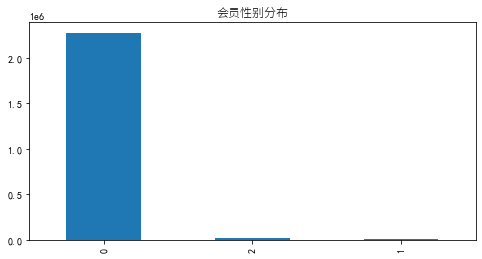

In [24]:
# 用户性别基本未知，这个标签基本没法用
plt.figure(figsize=(8,4))
plt.title('会员性别分布', fontproperties=myfont)
train.customer_gender.value_counts().plot.bar()

#### 用户省份

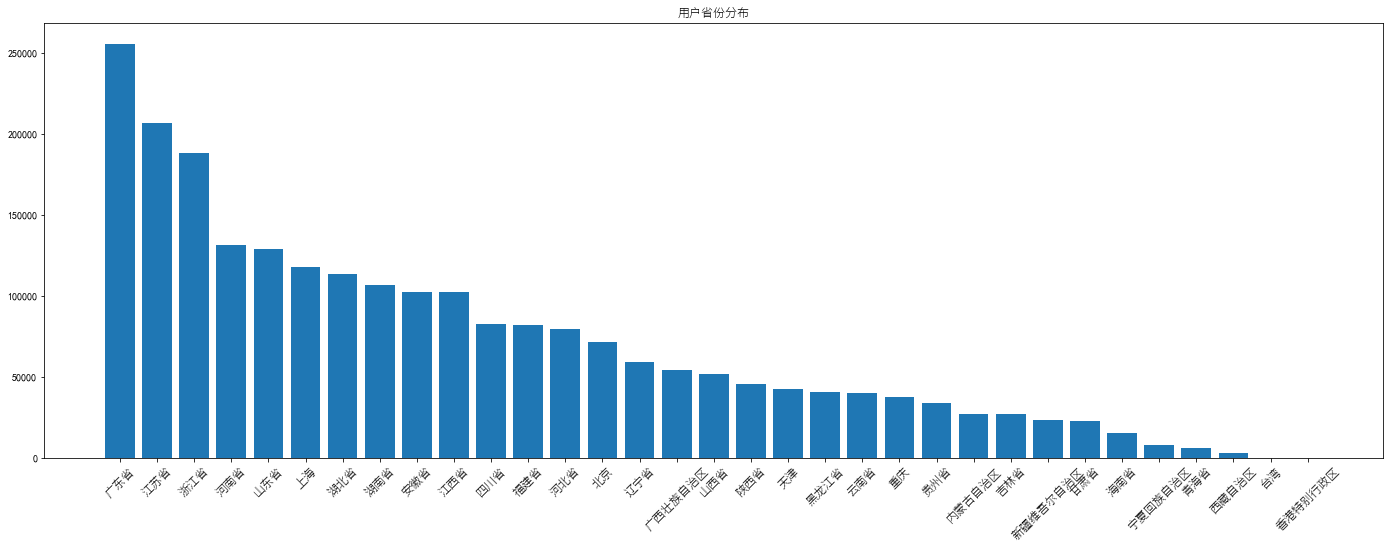

In [25]:
plt.figure(figsize=(24,8))
plt.title('用户省份分布',fontproperties=myfont)
x = train.customer_province.value_counts().index
plt.bar(train.customer_province.value_counts().index, train.customer_province.value_counts().values)
# 做坐标刻度
plt.xticks(x, fontproperties=myfont, rotation=45)
plt.show()

#### 会员状态

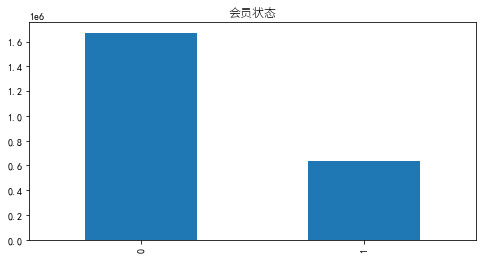

In [26]:
plt.figure(figsize=(8,4))
plt.title('会员状态',fontproperties=myfont)
train.member_status.value_counts().plot.bar()

In [27]:
train.member_status.value_counts()

0    1671081
1     635790
Name: member_status, dtype: int64

#### 是否会员

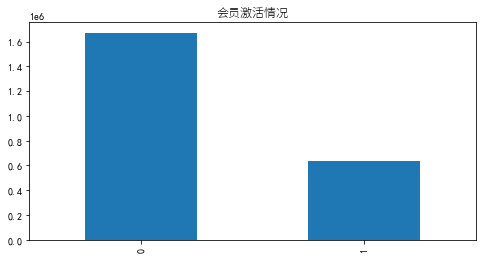

In [28]:
plt.figure(figsize=(8,4))
plt.title('会员激活情况',fontproperties=myfont)
train.is_member_actived.value_counts().plot.bar()

In [29]:
train.is_member_actived.value_counts()

0    1671081
1     635790
Name: is_member_actived, dtype: int64

#### 用户id分布

C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


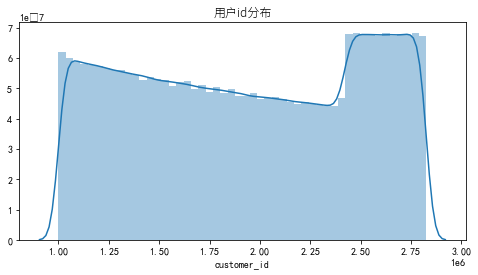

In [30]:
plt.figure(figsize=(8,4))
plt.title('用户id分布',fontproperties=myfont)
sns.distplot(train.customer_id)

#### 用户行为

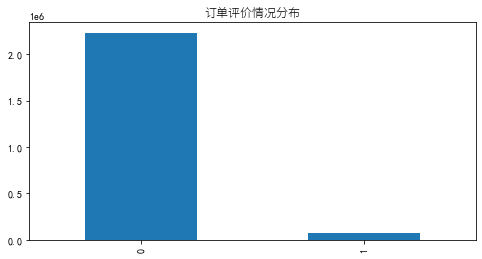

In [31]:
plt.figure(figsize=(8,4))
plt.title('订单评价情况分布', fontproperties=myfont)
train.is_customer_rate.value_counts().plot.bar()

In [32]:
train[train['is_customer_rate']==1].describe()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_status,order_count,is_customer_rate,order_detail_status,...,goods_class_id,goods_price,goods_status,goods_has_discount,customer_city_id,customer_province_id,Year,Month,Day,Hour
count,7.246600e+04,7.246600e+04,72466.000000,72466.000000,72466.000000,72466.000000,72466.000000,72466.000000,72466.0,72466.000000,...,72466.000000,72445.000000,72466.000000,72466.000000,72466.000000,72466.000000,72466.000000,72466.000000,72466.000000,72466.000000
mean,2.333344e+06,2.130563e+06,1.555792,252.634578,90.121640,6.459193,5.997475,1.398670,1.0,5.997475,...,1494.551900,50.745098,1.053791,0.189772,172.109555,15.579210,2012.807717,4.275233,17.670949,11.282022
std,7.728181e+05,6.491457e+05,2.202484,241.346325,91.168829,15.919582,0.099854,0.946367,0.0,0.099854,...,754.096806,7.445544,0.303850,0.392123,106.911511,7.759176,0.394097,3.907941,8.880165,7.698248
min,1.001600e+06,1.001373e+06,1.000000,1.000000,0.010000,0.000000,1.000000,0.000000,1.0,1.000000,...,998.000000,-38.952281,0.000000,0.000000,0.000000,1.000000,2012.000000,1.000000,1.000000,0.000000
25%,1.665872e+06,1.568339e+06,1.000000,129.900000,52.900000,0.000000,6.000000,1.000000,1.0,6.000000,...,1038.000000,49.390780,1.000000,0.000000,71.000000,11.000000,2013.000000,1.000000,11.000000,3.000000
50%,2.327144e+06,2.132540e+06,1.000000,209.900000,76.900000,0.000000,6.000000,1.000000,1.0,6.000000,...,1153.000000,52.914932,1.000000,0.000000,167.000000,16.000000,2013.000000,2.000000,19.000000,12.000000
75%,2.998450e+06,2.700923e+06,2.000000,259.900000,98.700000,8.840000,6.000000,1.000000,1.0,6.000000,...,1498.000000,54.798674,1.000000,0.000000,266.000000,20.000000,2013.000000,6.000000,25.000000,18.000000
max,3.685487e+06,3.238355e+06,301.000000,14769.900000,7192.900000,969.440000,6.000000,12.000000,1.0,6.000000,...,6668.000000,92.350852,2.000000,1.000000,375.000000,33.000000,2013.000000,12.000000,31.000000,23.000000


用户进行订单评价的订单数为72466条

#### 商品分布

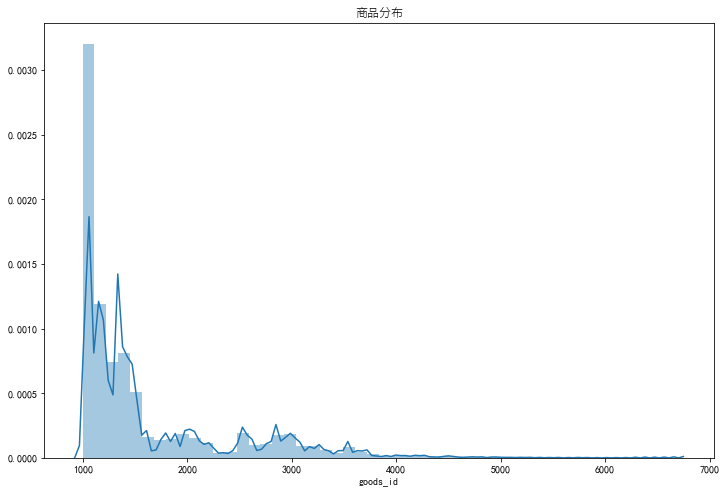

In [33]:
plt.figure(figsize=(12,8))
plt.title('商品分布', fontproperties=myfont)
sns.distplot(train.goods_id)

#### 商品类别

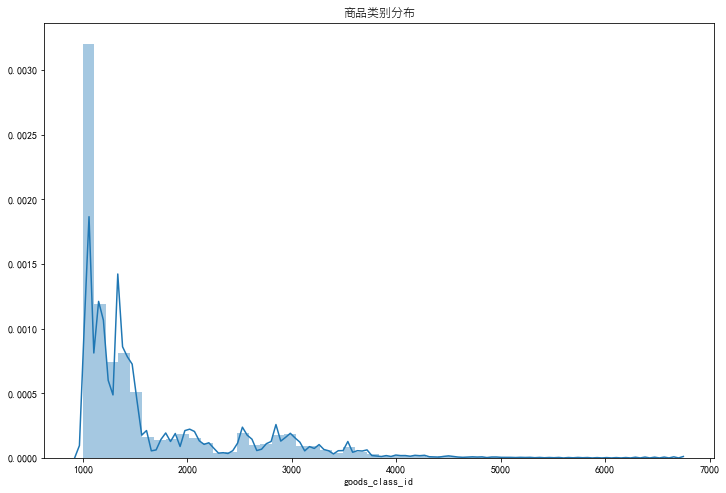

In [34]:
plt.figure(figsize=(12,8))
plt.title('商品类别分布', FontProperties=myfont)
sns.distplot(train.goods_class_id)

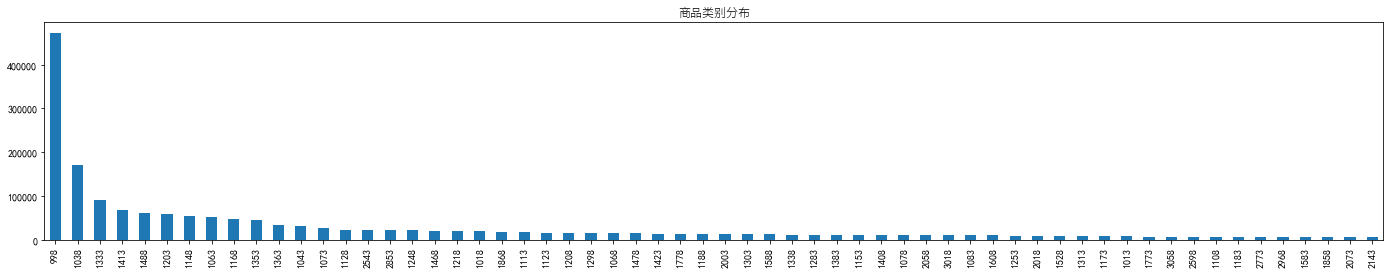

In [35]:
plt.figure(figsize=(24,4))
plt.title('商品类别分布', FontProperties=myfont)
train.goods_class_id.value_counts().head(60).plot.bar()

从上面两张图就会发现，数据集中，没有真正的商品类别，train.goods_class_id就是train.goods_id，后续可能需要用聚类算法对商品进行分类

#### 是否会员优惠

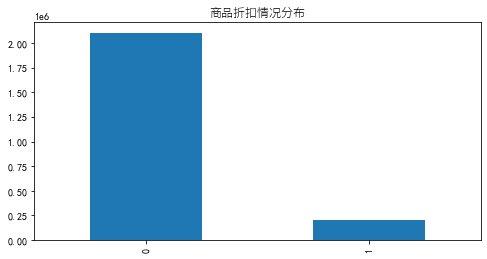

In [36]:
plt.figure(figsize=(8,4))
plt.title('商品折扣情况分布', FontProperties=myfont)
train.goods_has_discount.value_counts().plot.bar()

#### 商品价格

C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


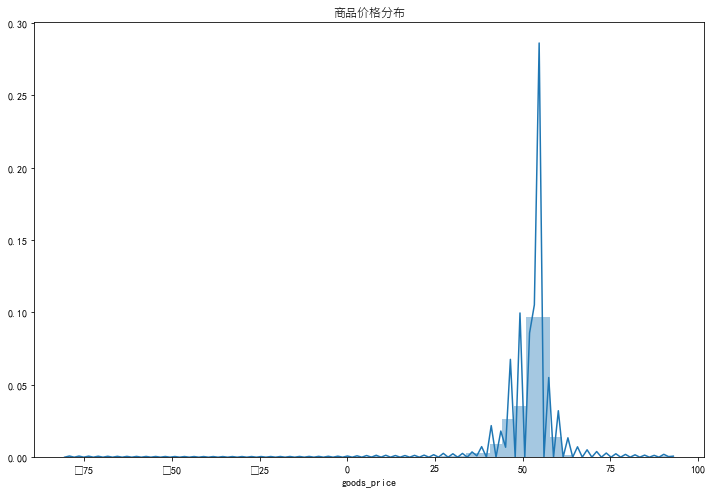

In [37]:
plt.figure(figsize=(12,8))
plt.title('商品价格分布', FontProperties=myfont)
sns.distplot(train.goods_price)

#### 异常交易数据分布
数据集中有9万多条order_status为101的数据，怀疑是交易失败、撤单数据，即使2月1日之后也有8万多条，这些数据是否要纳入考虑？这部分比较纠结，因为从用户的角度说，如果已经到了下单了以后才撤单，很可能是确实比较想买；但也无法排除恶意刷单的问题。

In [38]:
temp = train[train.order_status==101]

In [39]:
temp.order_pay_time.describe()

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   98145
unique                  66209
top       2013-02-02 10:00:18
freq                       84
first     2012-11-01 10:56:47
last      2013-08-31 23:58:24
Name: order_pay_time, dtype: object

In [40]:
temp = temp[temp.order_pay_time>'2013-02-01']
temp.describe()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_status,order_count,is_customer_rate,order_detail_status,...,goods_class_id,goods_price,goods_status,goods_has_discount,customer_city_id,customer_province_id,Year,Month,Day,Hour
count,8.069000e+04,8.069000e+04,80690.000000,80690.000000,80690.000000,80690.000000,80690.0,80690.000000,80690.0,80690.0,...,80690.000000,80681.000000,80690.000000,80690.000000,80690.000000,80690.000000,80690.0,80690.000000,80690.000000,80690.000000
mean,2.367592e+06,2.159158e+06,1.628727,295.842292,113.194452,2.369286,101.0,1.311166,0.0,101.0,...,1429.857541,52.599164,1.041058,0.123919,178.180803,15.996815,2013.0,5.117871,13.701400,12.962684
std,7.791512e+05,6.540363e+05,3.540653,380.475620,155.684910,10.017603,0.0,0.758133,0.0,0.0,...,640.106176,5.780158,0.379437,0.329491,106.804837,7.494300,0.0,2.344358,8.942865,5.809662
min,1.001547e+06,1.001340e+06,1.000000,0.010000,0.010000,0.000000,101.0,1.000000,0.0,101.0,...,998.000000,-26.782614,0.000000,0.000000,0.000000,0.000000,2013.0,2.000000,1.000000,0.000000
25%,1.689368e+06,1.588600e+06,1.000000,199.000000,66.900000,0.000000,101.0,1.000000,0.0,101.0,...,1018.000000,50.917234,1.000000,0.000000,80.000000,11.000000,2013.0,3.000000,6.000000,10.000000
50%,2.373472e+06,2.172060e+06,1.000000,239.900000,89.900000,0.000000,101.0,1.000000,0.0,101.0,...,1168.000000,53.956080,1.000000,0.000000,185.000000,16.000000,2013.0,5.000000,13.000000,12.000000
75%,3.049230e+06,2.740576e+06,2.000000,299.700000,109.900000,0.000000,101.0,1.000000,0.0,101.0,...,1488.000000,54.853561,1.000000,0.000000,273.000000,20.000000,2013.0,8.000000,21.000000,17.000000
max,3.685470e+06,3.238344e+06,479.000000,23990.000000,10035.000000,600.000000,101.0,16.000000,0.0,101.0,...,6563.000000,92.352598,2.000000,1.000000,375.000000,33.000000,2013.0,8.000000,31.000000,23.000000


#### 异常交易会员状态

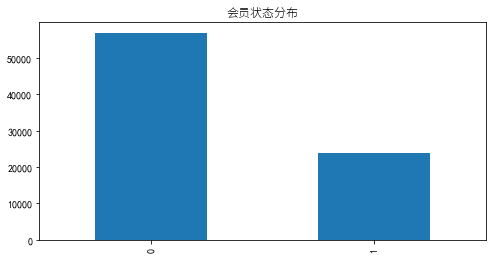

In [41]:
plt.figure(figsize=(8,4))
plt.title('会员状态分布', fontproperties=myfont)
temp.member_status.value_counts().plot.bar()

#### 异常订单交易金额

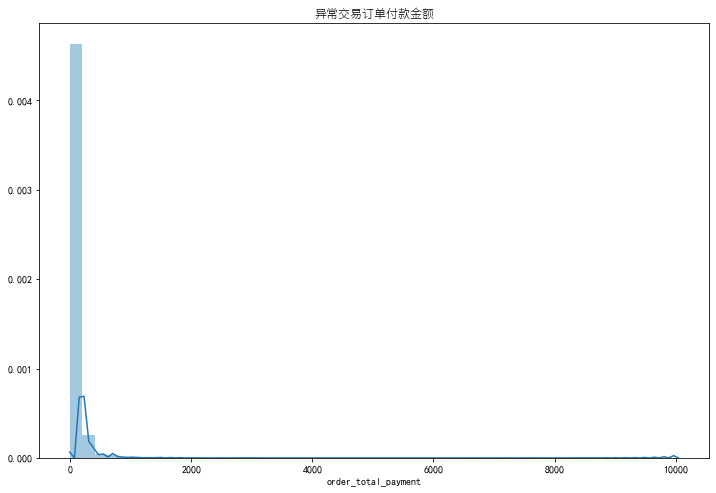

In [42]:
plt.figure(figsize=(12,8))
plt.title('异常交易订单付款金额', fontproperties=myfont)
sns.distplot(temp.order_total_payment)

#### 异常交易商品分布

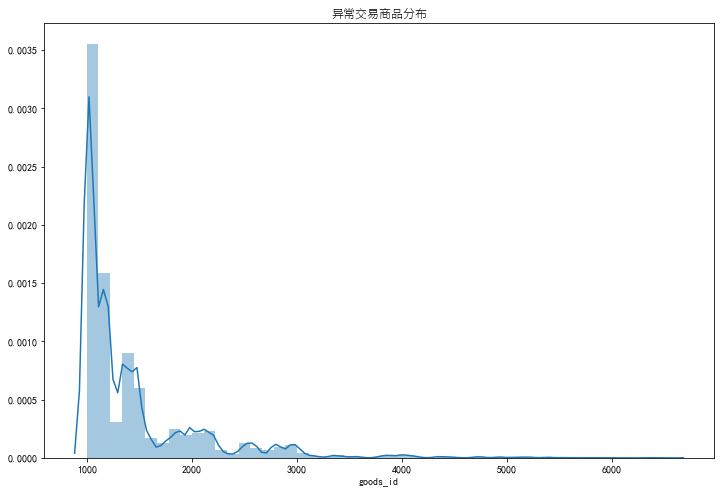

In [43]:
plt.figure(figsize=(12,8))
plt.title('异常交易商品分布', fontproperties=myfont)
sns.distplot(temp.goods_id)

#### 异常交易用户分布

C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


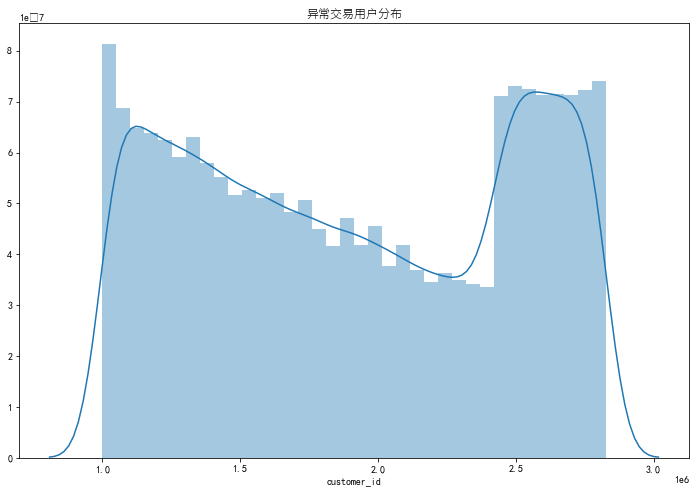

In [44]:
plt.figure(figsize=(12,8))
plt.title('异常交易用户分布', fontproperties=myfont)
sns.distplot(temp.customer_id)

#### 异常交易城市分布

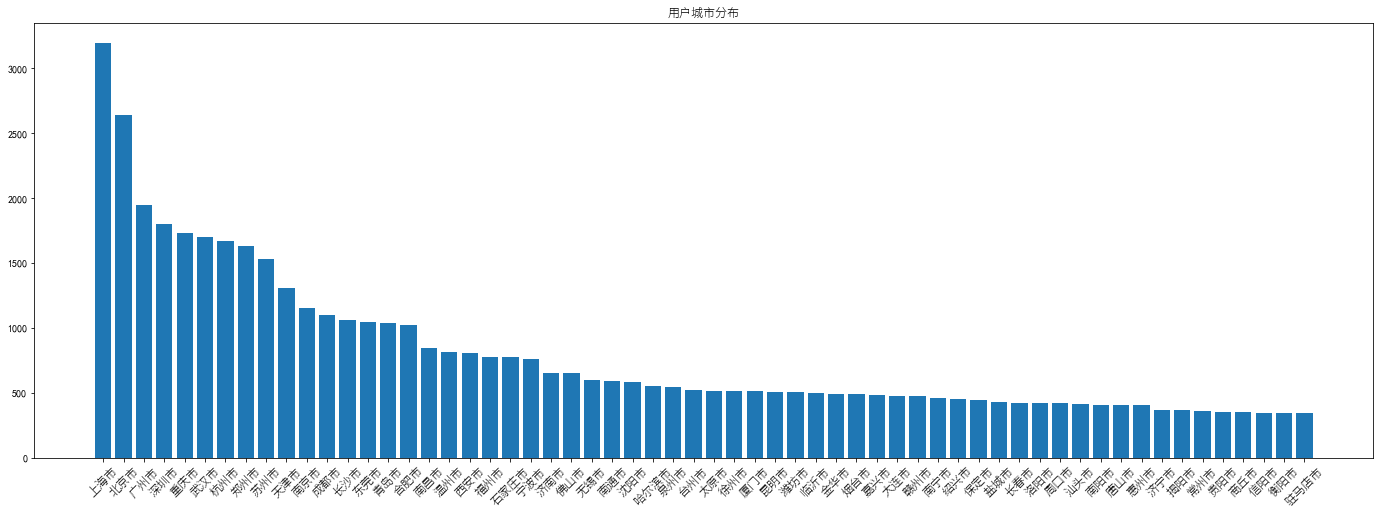

In [45]:
plt.figure(figsize=(24,8))
plt.title('用户城市分布',fontproperties=myfont)
x = temp.customer_city.value_counts().head(60).index
plt.bar(temp.customer_city.value_counts().head(60).index, temp.customer_city.value_counts().head(60).values)
# 做坐标刻度
plt.xticks(x, fontproperties=myfont, rotation=45)
plt.show()

#### 异常交易省份分布

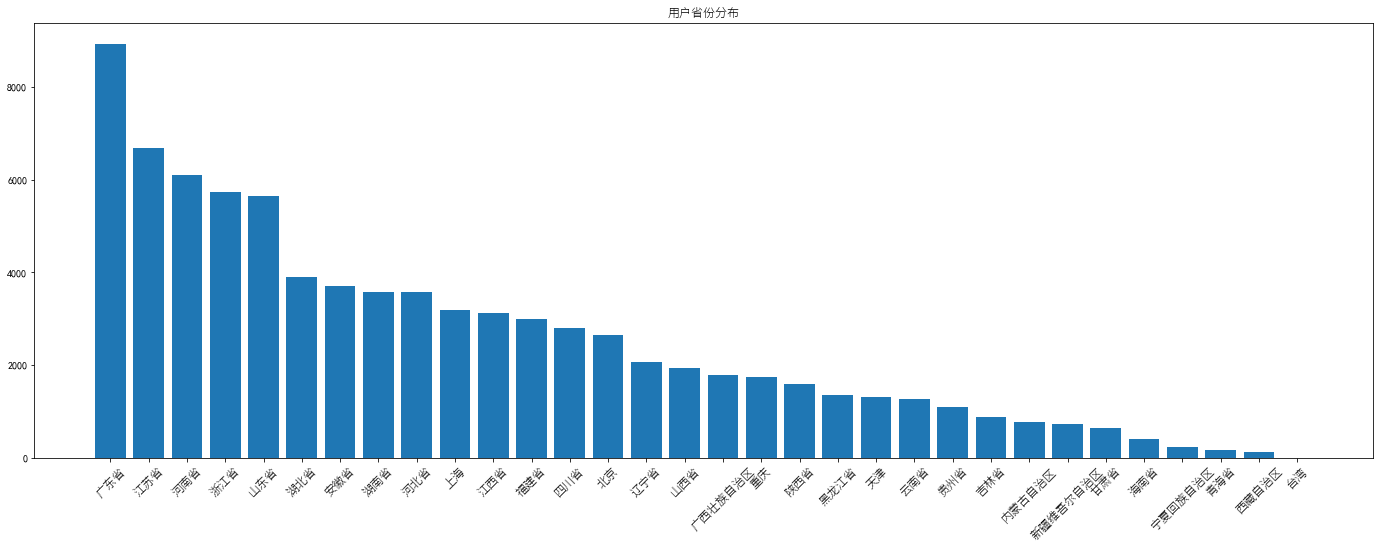

In [46]:
plt.figure(figsize=(24,8))
plt.title('用户省份分布',fontproperties=myfont)
x = temp.customer_province.value_counts().index
# train.customer_city.value_counts().head(30).plot.bar()
plt.bar(temp.customer_province.value_counts().index, temp.customer_province.value_counts().values)
# 做坐标刻度
plt.xticks(x, fontproperties=myfont, rotation=45)
plt.show()

#### 异常交易商品类别分布

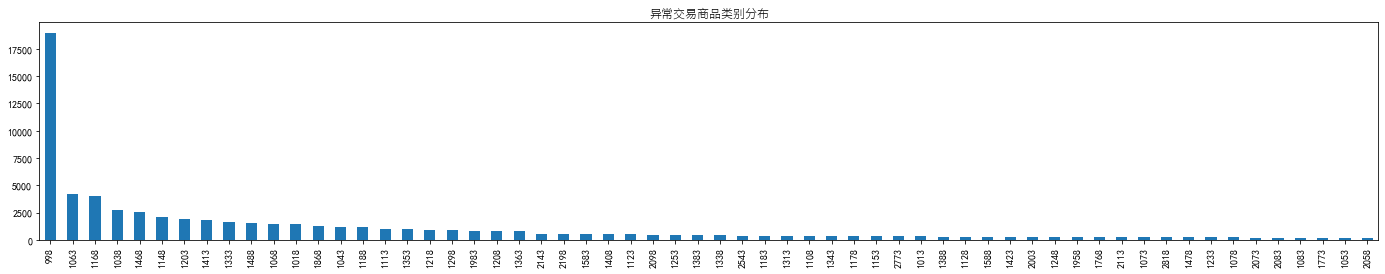

In [47]:
plt.figure(figsize=(24,4))
plt.title('异常交易商品类别分布', FontProperties=myfont)
temp.goods_class_id.value_counts().head(60).plot.bar()

#### 异常交易商品价格分布

C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\admin\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


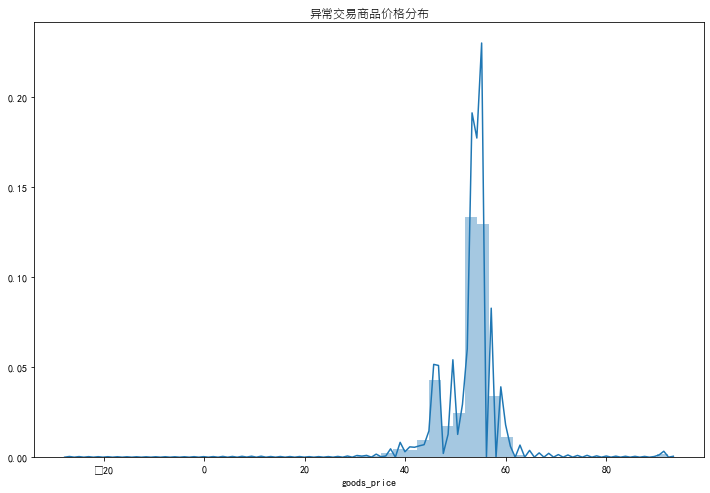

In [48]:
plt.figure(figsize=(12,8))
plt.title('异常交易商品价格分布', FontProperties=myfont)
sns.distplot(temp.goods_price)

#### 异常交易商品折扣情况分布

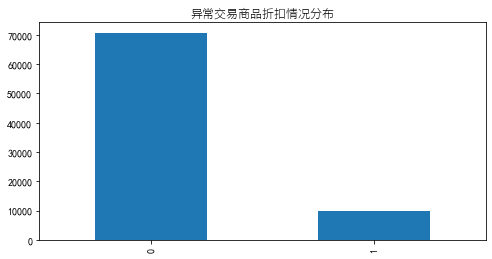

In [49]:
plt.figure(figsize=(8,4))
plt.title('异常交易商品折扣情况分布', FontProperties=myfont)
temp.goods_has_discount.value_counts().plot.bar()

#### 总结：通过上面的分析发现这些异常交易可能是参加了比较正常的秒杀类活动，又退单的情况。这也是用户活跃情况的重要指标，考虑保留。

## 第二部分 时间滑窗特征构建
时间滑窗在业务应用上被称为RFM模型，RFM模型最早是用来衡量客户价值和客户创利能力。理解RFM框架的思想是构造统计类特征的基础，其含义为： R（Recency）：客户最近一次交易消费时间的间隔。R值越大，表示客户交易发生的日期越久，反之则表示客户交易发生的日期越近。 F（Frequency）：客户在最近一段时间内交易消费的次数。F值越大，表示客户交易越频繁，反之则表示客户交易不够活跃。 M（Monetary）：客户在最近一段时间内交易消费的金额。M值越大，表示客户价值越高，反之则表示客户价值越低。

也就是说，时间滑窗特征本身是与业务紧密联系的，而在这类时间序列数据的比赛中，滑动时间窗口内的统计指标可以更加丰富，统计值一般会有最大值、最小值、均值、标准差、中位数、极差等。

### 纯时间序列滑窗
#### 训练集和测试集构造思路：<br/>

* 训练集<br/>
训练日期截止分别为2013.6.6、2013.6.20、2013.7.1、2013.7.15<br/>
标签为训练截止日期开始的30天有没有下过单<br/>
标签通过切片的形式构造<br/>
把4个部分训练集拼起来<br/>
* 验证集<br/>
验证数据到2013.8.1<br/>
标签为2013.8.1开始的30天有没有下过单<br/>
标签时间2013.8.1-2013.8.30<br/>
* 测试集<br/>
测试数据到2013.8.31<br/>
没有标签<br/>

In [50]:
train.head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,goods_status,goods_has_discount,goods_list_time,goods_delist_time,customer_city_id,customer_province_id,Year,Month,Day,Hour
0,1000000,1000000,1.0,239.9,96.9,0.0,2012-11-01 00:10:56,6,1.0,0,...,1.0,0,2014-10-25 11:08:07,2014-11-01 11:08:07,53,4,2012,11,1,0
1,1001530,1001327,2.0,288.0,96.9,0.0,2013-08-31 23:14:42,6,2.0,0,...,0.0,1,2013-08-28 17:27:50,2013-09-01 00:38:17,322,3,2013,8,31,23
2,1001531,1001327,2.0,288.0,96.9,0.0,2013-08-31 23:14:42,6,2.0,0,...,1.0,0,2014-10-29 18:21:05,2014-11-05 18:21:05,322,3,2013,8,31,23
3,1001532,1001328,3.0,180.0,89.7,0.0,2013-08-31 22:06:35,6,1.0,0,...,1.0,1,2014-10-25 11:00:00,2014-11-01 11:00:00,185,20,2013,8,31,22
4,1001533,1001329,1.0,159.9,65.9,0.0,2013-08-31 21:33:36,6,1.0,0,...,1.0,0,2014-10-23 15:35:33,2014-10-30 15:35:33,53,4,2013,8,31,21


In [51]:
# 训练集全部用户数量
len(train['customer_id'].unique())

1585986

In [52]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1585986 entries, 1000000 to 2826574
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   result  1585986 non-null  float64
dtypes: float64(1)
memory usage: 24.2 MB


In [53]:
test.head()

,result
customer_id,
1000000,0.0
1000014,0.0
1000034,0.0
1000046,0.0
1000048,0.0


从上面的比对可以看出，这里要预测的是全体用户未来一个月的购买情况，训练集和测试集的id完全重合，没有需要特别处理的地方

#### 构造时间滑窗特征
* 时间滑窗构造<br/>
考虑到按周、按月的订单规律性变化，时间滑窗往往是7和30的倍数<br/>
一般选取的特征是滑窗中的基本统计值，最大、最小、均值、中位数、求和等等<br/>

#### 每日付款金额

In [54]:
# 将用户下单金额按天进行汇总
df = train[train.order_pay_time>'2013-02-01']
df['date'] = pd.DatetimeIndex(df['order_pay_time']).date
df_payment = df[['customer_id','date','order_total_payment']]

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
len(df_payment['customer_id'].unique())

685471

注意，成功交易的客户数量不等于全部客户数量，说明有相当一部分客户虽然下过单，但是没有成功的订单，那么这些客户自然应当算在训练集之外。 数据合并时，由于test.csv中，已经设置了默认0值，只需要和训练后的预测标签做一个left join就可以了

In [56]:
df_payment = df_payment.groupby(['date','customer_id']).agg({'order_total_payment': ['sum']})
df_payment.columns = ['day_total_payment']
df_payment.reset_index(inplace=True)

In [57]:
df_payment.head()

,date,customer_id,day_total_payment
0,2013-02-01,1000434,79.9
1,2013-02-01,1000997,79.9
2,2013-02-01,1003010,79.9
3,2013-02-01,1003873,371.4
4,2013-02-01,1004890,183.8


In [58]:
df_payment = df_payment.set_index(
    ["customer_id", "date"])[["day_total_payment"]].unstack(level=-1).fillna(0)# unstack(level=-1) 该操作会将行中数据透视到列,level: 默认为-1，即行索引的最后一级
df_payment.columns = df_payment.columns.get_level_values(1)# get_level_values(1)# 行索引有多个，索引第2个的值

In [59]:
df_payment.columns

DatetimeIndex(['2013-02-01', '2013-02-02', '2013-02-03', '2013-02-04',
               '2013-02-05', '2013-02-06', '2013-02-07', '2013-02-08',
               '2013-02-09', '2013-02-10',
               ...
               '2013-08-22', '2013-08-23', '2013-08-24', '2013-08-25',
               '2013-08-26', '2013-08-27', '2013-08-28', '2013-08-29',
               '2013-08-30', '2013-08-31'],
              dtype='datetime64[ns]', name='date', length=212, freq=None)

In [60]:
df_payment.head()

date,2013-02-01,2013-02-02,2013-02-03,2013-02-04,2013-02-05,2013-02-06,2013-02-07,2013-02-08,2013-02-09,2013-02-10,...,2013-08-22,2013-08-23,2013-08-24,2013-08-25,2013-08-26,2013-08-27,2013-08-28,2013-08-29,2013-08-30,2013-08-31
customer_id,,,,,,,,,,,,,,,,,,,,,
1000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 每日购买商品数量

In [61]:
df_goods = df[['customer_id','date','order_total_num']]
df_goods = df_goods.groupby(['date','customer_id']).agg({'order_total_num': ['sum']})
df_goods.columns = ['day_total_num']
df_goods.reset_index(inplace=True)
df_goods = df_goods.set_index(
    ["customer_id", "date"])[["day_total_num"]].unstack(level=-1).fillna(0)
df_goods.columns = df_goods.columns.get_level_values(1)

In [62]:
df_goods.head()

date,2013-02-01,2013-02-02,2013-02-03,2013-02-04,2013-02-05,2013-02-06,2013-02-07,2013-02-08,2013-02-09,2013-02-10,...,2013-08-22,2013-08-23,2013-08-24,2013-08-25,2013-08-26,2013-08-27,2013-08-28,2013-08-29,2013-08-30,2013-08-31
customer_id,,,,,,,,,,,,,,,,,,,,,
1000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


该场景每天都有成交记录，这样就不需要考虑生成完整时间段填充的问题

In [2]:
# 这是一个时间滑窗函数，获得dt之前minus天以来periods的dataframe，以便进一步计算
def get_timespan(df, dt, minus, periods, freq='D'):
    # get_timespan(df_payment, date(2013, 6, 6), 7, 7) 就是从df_payment中取出从20130606往前7天的日期范围的数据也就是20130530-20130605
    print('timedelta(days=minus)',timedelta(days=minus))
    print('dt',dt)
    # print('pd.date_range(dt - timedelta(days=minus)',pd.date_range(dt - timedelta(days=minus),periods=periods, freq=freq))
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

In [64]:
ttt2 = get_timespan(df_payment, date(2013, 6, 6), 7, 7)
ttt2

date,2013-05-30,2013-05-31,2013-06-01,2013-06-02,2013-06-03,2013-06-04,2013-06-05
customer_id,,,,,,,
1000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000034,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000046,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000069,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000105,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2826556,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2826558,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2826562,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# @from: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65/code
# @liscense: Apache 2.0
# @author: weijian
def reduce_mem_usage(props):
    # 计算当前内存
    start_mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage of the dataframe is :", start_mem_usg, "MB")
    
    # 哪些列包含空值，空值用-999填充。why：因为np.nan当做float处理
    NAlist = []
    for col in props.columns:
        # 这里只过滤了objectd格式，如果你的代码中还包含其他类型，请一并过滤
        if (props[col].dtypes != object):
            
            # print("**************************")
            # print("columns: ", col)
            # print("dtype before", props[col].dtype)
            
            # 判断是否是int类型
            isInt = False
            mmax = props[col].max()
            mmin = props[col].min()
            
            # Integer does not support NA, therefore Na needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(-999, inplace=True) # 用-999填充
                
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = np.fabs(props[col] - asint)
            result = result.sum()
            if result < 0.01: # 绝对误差和小于0.01认为可以转换的，要根据task修改
                isInt = True
            
            # make interger / unsigned Integer datatypes
            if isInt:
                if mmin >= 0: # 最小值大于0，转换成无符号整型
                    if mmax <= 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mmax <= 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mmax <= 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else: # 转换成有符号整型
                    if mmin > np.iinfo(np.int8).min and mmax < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mmin > np.iinfo(np.int16).min and mmax < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mmin > np.iinfo(np.int32).min and mmax < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mmin > np.iinfo(np.int64).min and mmax < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)  
            else: # 注意：这里对于float都转换成float16，需要根据你的情况自己更改
                props[col] = props[col].astype(np.float16)
            
            # print("dtype after", props[col].dtype)
            # print("********************************")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [4]:
def prepare_dataset(df_payment, df_goods, dt, is_train=True):
    X = {}
    # 整合用户id
    tmp = df_payment.reset_index()
    X['customer_id'] = tmp['customer_id']
    del tmp
    gc.collect()
    # 消费特征
    print('Preparing payment feature...')
    for i in [7,14,30,49,60,91,120]:
        tmp_1 = get_timespan(df_payment, dt, i, i)
        X['mean_%s' % i] = tmp_1.mean(axis=1).values
        X['median_%s' % i] = tmp_1.median(axis=1).values
        X['max_%s' % i] = tmp_1.max(axis=1).values
        X['sum_%s' % i] = tmp_1.sum(axis=1).values
        # 最近i天内销售额
        X['has_sales_days_in_last_%s' % i] = (tmp_1 != 0).sum(axis=1).values
        # 最后i天内有销售
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp_1 != 0) * np.arange(i)).max(axis=1).values
        # 第一个销售日在最后一个i天内
        X['first_has_sales_day_in_last_%s' % i] = ((tmp_1 != 0) * np.arange(i, 0, -1)).max(axis=1).values
        del tmp_1
        # 取dt日期往前推一周的i天前的数据
        tmp_2 = get_timespan(df_payment, dt + timedelta(weeks=-1), i, i)
        X['mean_%s_2' % i] = tmp_2.mean(axis=1).values
        X['median_%s_2' % i] = tmp_2.median(axis=1).values
        X['max_%s_2' % i] = tmp_2.max(axis=1).values
        del tmp_2
        gc.collect()

    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['day_%s_2018' % i] = get_timespan(df_payment, dt, i*30, 30).sum(axis=1).values

    for i in range(7):
        X['mean_4_dow{}_2013'.format(i)] = get_timespan(df_payment, dt, 56-i*2, 4, freq='14D').mean(axis=1).values
        # X['mean_20_dow{}_2013'.format(i)] = get_timespan(df, dt, 140-i, 20, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2013'.format(i)] = get_timespan(df_payment, dt, 140-i*2, 10, freq='14D').mean(axis=1).values
    
    # 商品数量特征，这里故意把时间和消费特征错开，提高时间滑窗的覆盖面
    print('Preparing num feature...')
    for i in [3,21,35,49,70,84,105]:
            tmp_1 = get_timespan(df_goods, dt, i, i)
            X['goods_mean_%s' % i] = tmp_1.mean(axis=1).values
            X['goods_median_%s' % i] = tmp_1.median(axis=1).values
            X['goods_max_%s' % i] = tmp_1.max(axis=1).values
            X['goods_sum_%s' % i] = tmp_1.sum(axis=1).values
            # 在过去i天内有多少商品销售
            X['goods_has_sales_days_in_last_%s' % i] = (tmp_1 > 0).sum(axis=1).values
            # 货物在最后i天有销售的天数
            X['goods_last_has_sales_day_in_last_%s' % i] = i - ((tmp_1 > 0) * np.arange(i)).max(axis=1).values
            # 货物在前i天有销售的天数
            X['goods_first_has_sales_day_in_last_%s' % i] = ((tmp_1 > 0) * np.arange(i, 0, -1)).max(axis=1).values
            # 取dt日期往前推一周的i天前的数据
            del tmp_1
            tmp_2 = get_timespan(df_goods, dt + timedelta(weeks=-1), i, i)
            X['goods_mean_%s_2' % i] = tmp_2.mean(axis=1).values
            X['goods_median_%s_2' % i] = tmp_2.median(axis=1).values
            X['goods_max_%s_2' % i] = tmp_2.max(axis=1).values
            X['goods_sum_%s_2' % i] = tmp_2.sum(axis=1).values
            del tmp_2
            gc.collect()
    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['goods_day_%s_2018' % i] = get_timespan(df_goods, dt, i*28, 28).sum(axis=1).values

    for i in range(7):
        X['goods_mean_4_dow{}_2013'.format(i)] = get_timespan(df_goods, dt, 56-i*2, 4, freq='14D').mean(axis=1).values
        # X['mean_20_dow{}_2013'.format(i)] = get_timespan(df, dt, 140-i, 20, freq='7D').mean(axis=1).values
        X['goods_mean_20_dow{}_2013'.format(i)] = get_timespan(df_goods, dt, 140-i*2, 10, freq='14D').mean(axis=1).values

    X = pd.DataFrame(X)
    
    reduce_mem_usage(X)
    
    if is_train:
        # 这样转换之后，打标签直接用numpy切片就可以了
        # 当然这里前提是确认付款总额没有负数的问题
        y = df_goods[pd.date_range(dt, periods=30)].max(axis=1).values
        y[y > 0] = 1
        return X, y
    return X

#### 生成滑窗数据
此处对内存占用要求非常高，尽量分步操作避免crash，即使如此，内存溢出仍然频繁出现，通过下面的办法进一步压缩数据集大小
#### 生成训练集
对此处进行优化，把训练集不曾涉及到的新增用户剔除，也就是说，模型研究的是已有用户的购买行为变化趋势。如果一个用户在8月中旬才第一次下单，那么就不会被放到训练集/验证集中，只会出现在测试集中。

内存限制的情况下，训练集和验证集时间的选取会比较纠结，既要考虑月份，也要考虑星期。

In [17]:
def make_slides(train,df_part,begin,end,column):
    # 将用户下单金额按天进行汇总
    df = train[(train.order_pay_time > begin)&(train.order_pay_time < end)]
    df = pd.merge(df,df_part,how='inner')
    df['date'] = pd.DatetimeIndex(df['order_pay_time']).date
    df = df[['customer_id', 'date', column]]
    df = df.groupby(['date', 'customer_id']).agg({column: ['sum']})
    df.columns = ['day_' + column]
    df.reset_index(inplace=True)
    df = df.set_index(
        ["customer_id", "date"])[['day_' + column]].unstack(level=-1).fillna(0)
    df.columns = df.columns.get_level_values(1)
    return df

In [84]:
# part1 2013.06.06之前的用户，在2013.06.06后30天的时间滑窗
df_0606 = train[(train.order_pay_time > '2013-01-01')&(train.order_pay_time <= '2013-06-06')][['customer_id']]
df_0606 = df_0606.drop_duplicates(['customer_id'])
df_part1_partment = make_slides(train,df_0606,'2013-01-01','2013-07-06','order_total_payment')
df_part1_goods = make_slides(train,df_0606,'2013-01-01','2013-07-06','order_total_num')
X_part1, y_part1 = prepare_dataset(df_part1_partment, df_part1_goods, date(2013, 6, 6))

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 976.3886108398438 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  219.39694023132324  MB
This is  22.470247788184285 % of the initial size


In [86]:
X_part1.to_pickle('./X_part1.pkl')
np.save("./y_part1.npy", y_part1)

In [87]:
# 清理内存
del df_0606
del df_part1_partment
del df_part1_goods
del X_part1
del y_part1
gc.collect()

29

In [89]:
# part2 2013.06.20之前的用户，在2013.06.20后30天的时间滑窗
df_0620 = train[(train.order_pay_time > '2013-01-15')&(train.order_pay_time <= '2013-06-20')][['customer_id']]
df_0620 = df_0620.drop_duplicates(['customer_id'])
df_part2_partment = make_slides(train,df_0620,'2013-01-15','2013-07-20','order_total_payment')
df_part2_goods = make_slides(train,df_0620,'2013-01-15','2013-07-20','order_total_num')
X_part2, y_part2 = prepare_dataset(df_part2_partment, df_part2_goods, date(2013, 6, 20))

Wall time: 0 ns
Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 970.6541137695312 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  215.2195339202881  MB
This is  22.17262883525872 % of the initial size


In [90]:
X_part2.to_pickle('./X_part2.pkl')
np.save("./y_part2.npy", y_part2)

In [91]:
%%time
del df_0620
del df_part2_partment
del df_part2_goods
del X_part2
del y_part2
gc.collect()

Wall time: 2.91 s


0

In [93]:
%%time
# part3 2013.07.01之前的用户，在2013.07.01后30天的时间滑窗
df_0701 = train[(train.order_pay_time > '2013-01-26')&(train.order_pay_time <= '2013-07-01')][['customer_id']]
df_0701 = df_0701.drop_duplicates(['customer_id'])
df_part3_partment = make_slides(train,df_0701,'2013-01-26','2013-07-31','order_total_payment')
df_part3_goods = make_slides(train,df_0701,'2013-01-26','2013-07-31','order_total_num')
X_part3, y_part3 = prepare_dataset(df_part3_partment, df_part3_goods, date(2013, 7, 1))

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 740.1360473632812 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  165.20903396606445  MB
This is  22.321441382921165 % of the initial size
Wall time: 1min 59s


In [94]:
X_part3.to_pickle('./X_part3.pkl')
np.save("./y_part3.npy", y_part3)

In [95]:
del df_0701
del df_part3_partment
del df_part3_goods
del X_part3
del y_part3
gc.collect()

10

In [100]:
%%time
# part4 2013.07.15之前的用户，在2013.07.15后30天的时间滑窗
df_0715 = train[(train.order_pay_time > '2013-02-10')&(train.order_pay_time <= '2013-07-15')][['customer_id']]
df_0715 = df_0715.drop_duplicates(['customer_id'])
df_part4_partment = make_slides(train,df_0715,'2013-02-10','2013-08-16','order_total_payment')
df_part4_goods = make_slides(train,df_0715,'2013-02-10','2013-08-16','order_total_num')
X_part4, y_part4 = prepare_dataset(df_part4_partment, df_part4_goods, date(2013, 7, 15))

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 486.11602783203125 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  107.06136322021484  MB
This is  22.023829104686094 % of the initial size
Wall time: 1min 8s


In [101]:
%%time
X_part4.to_pickle('./X_part4.pkl')
np.save("./y_part4.npy", y_part4)

Wall time: 978 ms


In [102]:
%%time
del df_0715
del df_part4_partment
del df_part4_goods
del X_part4
del y_part4
gc.collect()

Wall time: 217 ms


0

In [103]:
%%time
# 将四部分训练集整合
print("Preparing Train dataset...")
X_l, y_l = [], []
X_part1 = pd.read_pickle('./X_part1.pkl')
y_part1 = np.load('./y_part1.npy')
X_l.append(X_part1)
y_l.append(y_part1)
X_part2 = pd.read_pickle('./X_part2.pkl')
y_part2 = np.load('./y_part2.npy')
X_l.append(X_part2)
y_l.append(y_part2)
X_part3 = pd.read_pickle('./X_part3.pkl')
y_part3 = np.load('./y_part3.npy')
X_l.append(X_part3)
y_l.append(y_part3)
X_part4 = pd.read_pickle('./X_part4.pkl')
y_part4 = np.load('./y_part4.npy')
X_l.append(X_part4)
y_l.append(y_part4)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
print('done!')
del X_l
del y_l
del X_part1
del y_part1
del X_part2
del y_part2
del X_part3
del y_part3
del X_part4
del y_part4
gc.collect()
X_train.to_pickle('./X_train.pkl')
np.save("./y_train.npy", y_train)

Preparing Train dataset...
done!
Wall time: 15.2 s


#### 生成验证集

In [105]:
%%time
# 2013.08.01之前的用户，在2013.08.01后30天的时间滑窗
print("Preparing Validation dataset...")
df_0801 = train[(train.order_pay_time > '2013-03-01')&(train.order_pay_time <= '2013-08-01')][['customer_id']]
df_0801 = df_0801.drop_duplicates(['customer_id'])
df_part5_partment = make_slides(train,df_0801,'2013-03-01','2013-08-31','order_total_payment')
df_part5_goods = make_slides(train,df_0801,'2013-03-01','2013-08-31','order_total_num')
X_val, y_val = prepare_dataset(df_part5_partment, df_part5_goods, date(2013, 8, 1))

Preparing Validation dataset...
Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 518.7106323242188 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  113.85399150848389  MB
This is  21.949423129873256 % of the initial size
Wall time: 1min 19s


In [106]:
%%time
X_val.to_pickle('./X_val.pkl')
np.save("./y_val.npy", y_val)

Wall time: 1.29 s


In [107]:
%%time
del df_0801
del df_part5_partment
del df_part5_goods
gc.collect()

Wall time: 1.16 s


0

#### 生成测试集

In [108]:
%%time
# 2013.09.01之前的用户，在2013.09.01后30天的时间滑窗 
df_0901 = train[(train.order_pay_time > '2013-03-01')&(train.order_pay_time < '2013-09-01')][['customer_id']]
df_0901 = df_0901.drop_duplicates(['customer_id'])
df_test_partment = make_slides(train,df_0901,'2013-04-01','2013-09-01','order_total_payment')
df_test_goods = make_slides(train,df_0901,'2013-04-01','2013-09-01','order_total_num')
X_test = prepare_dataset(df_test_partment, df_test_goods, date(2013, 9, 1),is_train=False)

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 620.6754760742188 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  137.15829181671143  MB
This is  22.098229606917865 % of the initial size
Wall time: 1min 31s
Parser   : 168 ms


In [109]:
X_test.to_pickle('./X_test.pkl')

In [110]:
%%time
del df_0901
del df_test_partment
del df_test_goods
del X_test
gc.collect()

Wall time: 1.09 s


0

### 总结
纯时间序列滑窗也可以直接用模型开始训练，但是效果并不太好。 考虑到还有其它重要的数据维度，此时需要构建新的交叉特征。如用户X商品，用户X会员，用户X城市，用户X省份等，然后与时间滑窗数据整合。

纯时间滑窗还有个问题，面对当前这个非常稀疏的数据集，浪费了大量的内存空间。

### 用户基本特征
把地域、会员这些基本信息整合到训练数据中

In [111]:
df_customer = train[['member_id','customer_id','customer_gender','customer_province_id','customer_city_id','is_member_actived']]
# 删除重复行
df_customer = df_customer.drop_duplicates(['customer_id'])
df_customer.head()

,member_id,customer_id,customer_gender,customer_province_id,customer_city_id,is_member_actived
0,0,1000000,0,4,53,0
1,0,1001324,0,3,322,0
3,0,1001325,0,20,185,0
4,0,1001326,0,4,53,0
5,0,1001327,0,4,53,0


In [112]:
X_test = pd.read_pickle('./X_test.pkl')
X_train = pd.merge(X_train,df_customer,how='left')
X_val = pd.merge(X_val,df_customer,how='left')
X_test = pd.merge(X_test,df_customer,how='left')

In [113]:
X_train.to_pickle('X_train.pkl')
X_val.to_pickle('X_val.pkl')
X_test.to_pickle('X_test.pkl')

## 第三部分 模型训练

In [2]:
# 读取数据
X_train = pd.read_pickle('./X_train.pkl')
X_val = pd.read_pickle('./X_val.pkl')
X_test = pd.read_pickle('./X_test.pkl')

In [3]:
y_train = np.load("./y_train.npy")
y_val = np.load("./y_val.npy")

In [4]:
# 合并数据
X_l, y_l = [], []
X_l.append(X_train)
y_l.append(y_train)
X_l.append(X_val)
y_l.append(y_val)

In [6]:
X_train_cv = pd.concat(X_l, axis=0)
y_train_cv = np.concatenate(y_l, axis=0)

In [12]:
del X_l
del y_l
gc.collect()
X_train_cv.to_pickle('./X_train_cv.pkl')
np.save("./y_train_cv.npy", y_train_cv)

In [26]:
X_train_cv = pd.read_pickle('./X_train_cv.pkl')
y_train_cv = np.load("./y_train_cv.npy")
X_test = pd.read_pickle('./X_test.pkl')

In [22]:
X_train = pd.read_pickle('./X_train.pkl')

#### 因计算量太大（笔记本内存原因），本次不考虑XGBoost

#### XGBoost

In [ ]:
%%time
import xgboost as xgb

print('Step1')
xgb_train = xgb.DMatrix(X_train_cv.values, label=y_train_cv)
print('Step2')
xgb_test = xgb.DMatrix(X_test.values)

params = {'booster': 'gbtree',
          'objective': 'rank:pairwise',  # 二分类的问题
          # 'gamma':0.1,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
          'max_depth': 5,  # 构建树的深度，越大越容易过拟合
          # 'lambda':2,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
          'subsample': 0.7,  # 随机采样训练样本
          'colsample_bytree': 0.7,  # 生成树时进行的列采样
          'min_child_weight': 2,
          # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
          # ，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
          # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
          'scale_pos_weight': 63,
          'silent': 0,  # 设置成1则没有运行信息输出，最好是设置为0.
          'eta': 0.03,  # 如同学习率
          # 'nthread': 8,  # cpu 线程数
          'eval_metric': 'logloss'  # 评价方式
          }

plst = list(params.items())
num_rounds = 20  # 迭代次数
watchlist = [(xgb_train, 'train')]
# early_stopping_rounds    当设置的迭代次数较大时，early_stopping_rounds 可在一定的迭代次数内准确率没有提升就停止训练
print('Step3')
model = xgb.train(plst, xgb_train, num_rounds, watchlist)
print('Step4')
pred_value = model.predict(xgb_test)

#### CatBoost

In [23]:
# 找到类别型特征的位置
X_train.columns.get_indexer(['customer_id','member_id','customer_gender','customer_province_id','customer_city_id',
'is_member_actived','user_product_mode','user_product_mode_1','user_product_mode_2'])

array([  0, 182, 183, 184, 185, 186,  -1,  -1,  -1], dtype=int64)

In [24]:
cat_features = [0, 182, 183, 184, 185, 186]

In [25]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=20,
    learning_rate=0.1,
    loss_function='Logloss',
    scale_pos_weight=63,
    verbose=5
)
model.fit(
    X_train_cv, y_train_cv,
    cat_features=cat_features
)

0:	learn: 0.6688002	total: 4.2s	remaining: 1m 19s
5:	learn: 0.5101730	total: 17.1s	remaining: 39.8s
10:	learn: 0.4258895	total: 29.9s	remaining: 24.5s
15:	learn: 0.3927031	total: 42.8s	remaining: 10.7s
19:	learn: 0.3840942	total: 52.3s	remaining: 0us


In [26]:
cat_pred = model.predict_proba(data=X_test)[:,1]

In [27]:
cat_pred

array([0.62247893, 0.10787898, 0.26685457, ..., 0.5025656 , 0.76843314,
       0.94210921])

#### 交叉验证

In [8]:
%matplotlib inline
from catboost import CatBoostClassifier, Pool, cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
# params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.1

cv_data = cv(
    params = params,
    pool = Pool(X_train_cv, label=y_train_cv, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [9]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.504935,0.000740,0.504932,0.000757
1,1,0.377912,0.002339,0.377896,0.002394
2,2,0.288686,0.002333,0.288670,0.002290
3,3,0.226384,0.001517,0.226366,0.001324
4,4,0.183134,0.000819,0.183117,0.000838


In [12]:
cv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   iterations          80 non-null     int64  
 1   test-Logloss-mean   80 non-null     float64
 2   test-Logloss-std    80 non-null     float64
 3   train-Logloss-mean  80 non-null     float64
 4   train-Logloss-std   80 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 3.2 KB


In [13]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.0493±0.0003 on step 79


#### 自动调参

In [14]:
import hyperopt

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric='Accuracy',
        random_seed=2020,
        scale_pos_weight=60,
        verbose=False,
        loss_function='Logloss',
    )
    
    cv_data = cv(
        Pool(X_train_cv, y_train_cv, cat_features=cat_features),
        model.get_params()
    )
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [ ]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

In [ ]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric='Accuracy',
    random_seed=2020,
    scale_pos_weight=60,
    verbose=False,
    loss_function='Logloss',
)
cv_data = cv(Pool(X_train_cv, y_train_cv, cat_features=cat_features), model.get_params())

In [ ]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

In [ ]:
test_pred = model.predict(X_test)

#### LightGBM

In [28]:
import lightgbm as lgb

print("Training and predicting models...")

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    # 'metric': {'auc','binary_logloss'},
    'metric': {'binary_logloss'},
    'num_leaves': 199,
    'max_depth': 11,
    'max_bin': 50,
    'min_data_in_leaf': 35,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.65,
    'bagging_freq': 4,
    'scale_pos_weight': 63
}

MAX_ROUNDS = 100
val_pred = []
test_pred = []
cate_vars = ['customer_id','member_id','customer_gender','customer_province_id',
'customer_city_id','is_member_actived']

dtrain = lgb.Dataset(
    X_train_cv, label=y_train_cv
)
bst = lgb.train(
    params, dtrain, num_boost_round=MAX_ROUNDS,
    categorical_feature= cate_vars
)

Training and predicting models...


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['customer_city_id', 'customer_gender', 'customer_id', 'customer_province_id', 'is_member_actived', 'member_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Number of positive: 45917, number of negative: 2834550
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.961423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7779
[LightGBM] [Info] Number of data points in the train set: 2880467, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015941 -> initscore=-4.122803
[LightGBM] [Info] Start training from score -4.122803


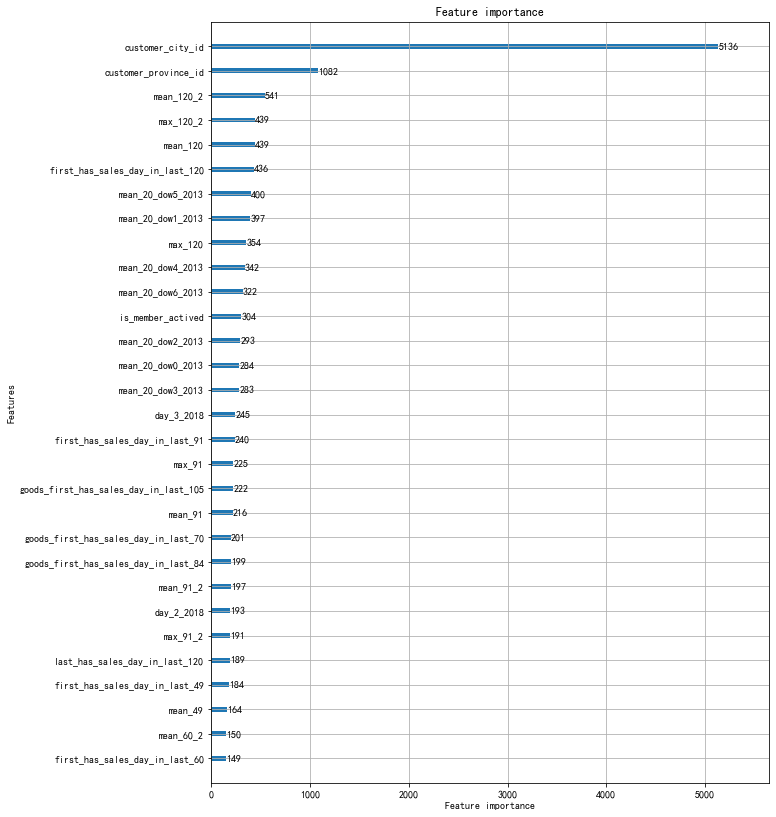

In [29]:
from lightgbm import plot_importance,plot_split_value_histogram

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax,max_num_features=30)
    
plot_features(bst, (10,14))

In [19]:
X_train = pd.read_pickle('./X_train.pkl')

In [30]:
pd.DataFrame({'fea':X_train.columns, 'imp':bst.feature_importance()}).sort_values('imp',ascending = False)

,fea,imp
185,customer_city_id,5136
184,customer_province_id,1082
68,mean_120_2,541
70,max_120_2,439
61,mean_120,439
...,...,...
129,goods_median_49_2,0
133,goods_median_70,0
140,goods_median_70_2,0
144,goods_median_84,0


In [31]:
lgb_pred = bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS)

In [32]:
lgb_pred

array([0.49042498, 0.34603002, 0.50758239, ..., 0.45869848, 0.6515696 ,
       0.74878439])

### 生成结果并验证

#### 融合

In [33]:
test_pred = (cat_pred + lgb_pred)/2

In [34]:
test_pred

array([0.55645195, 0.2269545 , 0.38721848, ..., 0.48063204, 0.71000137,
       0.8454468 ])

In [35]:
len(test_pred)

484245

In [36]:
print("Preparing Predict dataset...")

print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
{    "customer_id": X_test.customer_id, 
    "pred": y_test}
)
df_preds.head()

Preparing Predict dataset...
Making submission...


,customer_id,pred
0,1000014,0.556452
1,1000046,0.226954
2,1000069,0.387218
3,1000105,0.900406
4,1000109,0.276677


In [37]:
df_preds.tail()

,customer_id,pred
484240,2826556,0.603776
484241,2826558,0.742671
484242,2826562,0.480632
484243,2826570,0.710001
484244,2826574,0.845447


In [38]:
df_preds[df_preds.customer_id==1000014].head()

,customer_id,pred
0,1000014,0.556452


In [39]:
train = pd.read_csv('./train.csv')
train[train.customer_id==1000014].head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
155115,1181340,1155016,1.0,129.9,66.9,0.0,2013-08-03 21:34:49,6,1.0,0.0,...,NaN,NaN,NaN,1038,1038,49.554744,1.0,0.0,2014-10-28 14:26:28,2014-11-04 14:26:28


In [43]:
submission.to_csv('./submission2.csv')

In [45]:
train.order_pay_time.min()

'2012-11-01 00:00:07'

In [46]:
train.order_pay_time.max()

'2013-08-31 23:59:59'

## 全样本构造测试集数据、预测、模型融合

#### 每日付款金额全样本

In [8]:
# 将用户下单金额按天进行汇总
df = train[train.order_pay_time>'2012-11-01']
df['date'] = pd.DatetimeIndex(df['order_pay_time']).date
df_payment_total = df[['customer_id','date','order_total_payment']]

In [6]:
len(df_payment_total['customer_id'].unique())

1585986

In [9]:
df_payment_total = df_payment_total.groupby(['date','customer_id']).agg({'order_total_payment': ['sum']})
df_payment_total.columns = ['day_total_payment']
df_payment_total.reset_index(inplace=True)

In [8]:
df_payment_total.head()

,date,customer_id,day_total_payment
0,2012-11-01,1000000,96.9
1,2012-11-01,1004513,657.0
2,2012-11-01,1004899,119.9
3,2012-11-01,1008949,66.9
4,2012-11-01,1009410,135.9


In [13]:
df_payment_total.to_pickle('./df_payment_total.pkl')

In [10]:
df_payment_total = df_payment_total.set_index(
    ["customer_id", "date"])[["day_total_payment"]].unstack(level=-1).fillna(0)# unstack(level=-1) 该操作会将行中数据透视到列,level: 默认为-1，即行索引的最后一级
df_payment_total.columns = df_payment_total.columns.get_level_values(1)# get_level_values(1)# 行索引有多个，索引第2个的值

In [10]:
df_payment_total.head()

date,2012-11-01,2012-11-02,2012-11-03,2012-11-04,2012-11-05,2012-11-06,2012-11-07,2012-11-08,2012-11-09,2012-11-10,...,2013-08-22,2013-08-23,2013-08-24,2013-08-25,2013-08-26,2013-08-27,2013-08-28,2013-08-29,2013-08-30,2013-08-31
customer_id,,,,,,,,,,,,,,,,,,,,,
1000000,96.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 每日购买商品数量全样本

In [11]:
df_goods_total = df[['customer_id','date','order_total_num']]
df_goods_total = df_goods_total.groupby(['date','customer_id']).agg({'order_total_num': ['sum']})
df_goods_total.columns = ['day_total_num']
df_goods_total.reset_index(inplace=True)

In [12]:
df_goods_total = df_goods_total.set_index(
    ["customer_id", "date"])[["day_total_num"]].unstack(level=-1).fillna(0)
df_goods_total.columns = df_goods_total.columns.get_level_values(1)

In [13]:
df_goods_total.head()

date,2012-11-01,2012-11-02,2012-11-03,2012-11-04,2012-11-05,2012-11-06,2012-11-07,2012-11-08,2012-11-09,2012-11-10,...,2013-08-22,2013-08-23,2013-08-24,2013-08-25,2013-08-26,2013-08-27,2013-08-28,2013-08-29,2013-08-30,2013-08-31
customer_id,,,,,,,,,,,,,,,,,,,,,
1000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df_goods_total.to_pickle('./df_goods_total.pkl')

In [ ]:
'''def make_slides(train,df_part,begin,end,column):
    # 将用户下单金额按天进行汇总
    df = train[(train.order_pay_time > begin)&(train.order_pay_time < end)]
    df = pd.merge(df,df_part,how='inner')
    df['date'] = pd.DatetimeIndex(df['order_pay_time']).date
    df = df[['customer_id', 'date', column]]
    df = df.groupby(['date', 'customer_id']).agg({column: ['sum']})
    df.columns = ['day_' + column]
    df.reset_index(inplace=True)
    df = df.set_index(
        ["customer_id", "date"])[['day_' + column]].unstack(level=-1).fillna(0)
    df.columns = df.columns.get_level_values(1)
    return df'''

In [5]:
df_payment_total = pd.read_pickle('./df_payment_total.pkl')
df_goods_total = pd.read_pickle('./df_goods_total.pkl')

In [6]:
%%time
# 构造预测10月份购买情况的训练数据集 2013-08-31之前的用户，在2013-08-31后30天的时间滑窗
#df_0831 = train[train.order_pay_time < '2013-09-01'][['customer_id']]
#df_0831 = df_0831.drop_duplicates(['customer_id'])
#print(len(df_0831['customer_id'].unique()))
#df_total_payment = make_slides(train,df_0831,'2012-11-01','2013-08-31','order_total_payment')
#df_total_goods = make_slides(train,df_0831,'2012-11-01','2013-08-31','order_total_num')
X_total = prepare_dataset(df_payment_total, df_goods_total, date(2013, 9, 1),is_train=False)

Preparing payment feature...
timedelta(days=minus) 7 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 7 days, 0:00:00
dt 2013-08-25
timedelta(days=minus) 14 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 14 days, 0:00:00
dt 2013-08-25
timedelta(days=minus) 30 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 30 days, 0:00:00
dt 2013-08-25
timedelta(days=minus) 49 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 49 days, 0:00:00
dt 2013-08-25
timedelta(days=minus) 60 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 60 days, 0:00:00
dt 2013-08-25
timedelta(days=minus) 91 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 91 days, 0:00:00
dt 2013-08-25
timedelta(days=minus) 120 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 120 days, 0:00:00
dt 2013-08-25
timedelta(days=minus) 30 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 60 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 90 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 56 days, 0:00:00
dt 2013-09-01
timedelta(days=mi

In [7]:
X_total

,customer_id,mean_7,median_7,max_7,sum_7,has_sales_days_in_last_7,last_has_sales_day_in_last_7,first_has_sales_day_in_last_7,mean_7_2,median_7_2,...,goods_mean_4_dow2_2013,goods_mean_20_dow2_2013,goods_mean_4_dow3_2013,goods_mean_20_dow3_2013,goods_mean_4_dow4_2013,goods_mean_20_dow4_2013,goods_mean_4_dow5_2013,goods_mean_20_dow5_2013,goods_mean_4_dow6_2013,goods_mean_20_dow6_2013
0,1000000,0.0,0.0,0.0,0.0,0,7,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1000014,0.0,0.0,0.0,0.0,0,7,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,1000034,0.0,0.0,0.0,0.0,0,7,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,1000046,0.0,0.0,0.0,0.0,0,7,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099976
4,1000048,0.0,0.0,0.0,0.0,0,7,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585981,2826570,0.0,0.0,0.0,0.0,0,7,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1585982,2826571,0.0,0.0,0.0,0.0,0,7,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1585983,2826572,0.0,0.0,0.0,0.0,0,7,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1585984,2826573,0.0,0.0,0.0,0.0,0,7,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [12]:
X_total.to_pickle('./X_total.pkl')

In [ ]:
# 全量样本的测试集维度要与训练集样本的维度保持一致 要将用户特征进行merge
df_customer = train[['member_id','customer_id','customer_gender','customer_province_id','customer_city_id','is_member_actived']]
# 删除重复行
df_customer = df_customer.drop_duplicates(['customer_id'])
df_customer.head()
X_total = pd.merge(X_total,df_customer,how='left')
X_total.to_pickle('X_total.pkl')

#### CatBoost全样本

In [2]:
X_total = pd.read_pickle('./X_total.pkl')
X_train_cv = pd.read_pickle('./X_train_cv.pkl')
y_train_cv = np.load("./y_train_cv.npy")

In [3]:
cat_features = [0, 182, 183, 184, 185, 186]

In [4]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=20,
    learning_rate=0.1,
    loss_function='Logloss',
    scale_pos_weight=63,
    verbose=5
)
model.fit(
    X_train_cv, y_train_cv,
    cat_features=cat_features
)

0:	learn: 0.6688002	total: 4.29s	remaining: 1m 21s
5:	learn: 0.5101730	total: 16.7s	remaining: 39.1s
10:	learn: 0.4258895	total: 27.8s	remaining: 22.7s
15:	learn: 0.3927031	total: 40.1s	remaining: 10s
19:	learn: 0.3840942	total: 48.9s	remaining: 0us


In [5]:
cat_pred = model.predict_proba(data=X_total)[:,1]

In [6]:
cat_pred

array([0.0244503 , 0.62247893, 0.44075747, ..., 0.09226693, 0.06922661,
       0.94210921])

In [7]:
len(cat_pred)

1585986

In [9]:
np.save("./catboost_pred.npy", cat_pred)

In [3]:
cat_pred = np.load("./catboost_pred.npy")

#### LightGBM全样本

In [4]:
import lightgbm as lgb

print("Training and predicting models...")

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    # 'metric': {'auc','binary_logloss'},
    'metric': {'binary_logloss'},
    'num_leaves': 199,
    'max_depth': 11,
    'max_bin': 50,
    'min_data_in_leaf': 35,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.65,
    'bagging_freq': 4,
    'scale_pos_weight': 63
}

MAX_ROUNDS = 100
val_pred = []
test_pred = []
cate_vars = ['customer_id','member_id','customer_gender','customer_province_id',
'customer_city_id','is_member_actived']

dtrain = lgb.Dataset(
    X_train_cv, label=y_train_cv
)
bst = lgb.train(
    params, dtrain, num_boost_round=MAX_ROUNDS,
    categorical_feature= cate_vars
)

Training and predicting models...


C:\Users\admin\Anaconda3\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['customer_city_id', 'customer_gender', 'customer_id', 'customer_province_id', 'is_member_actived', 'member_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Info] Number of positive: 45917, number of negative: 2834550
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.913285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7779
[LightGBM] [Info] Number of data points in the train set: 2880467, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015941 -> initscore=-4.122803
[LightGBM] [Info] Start training from score -4.122803


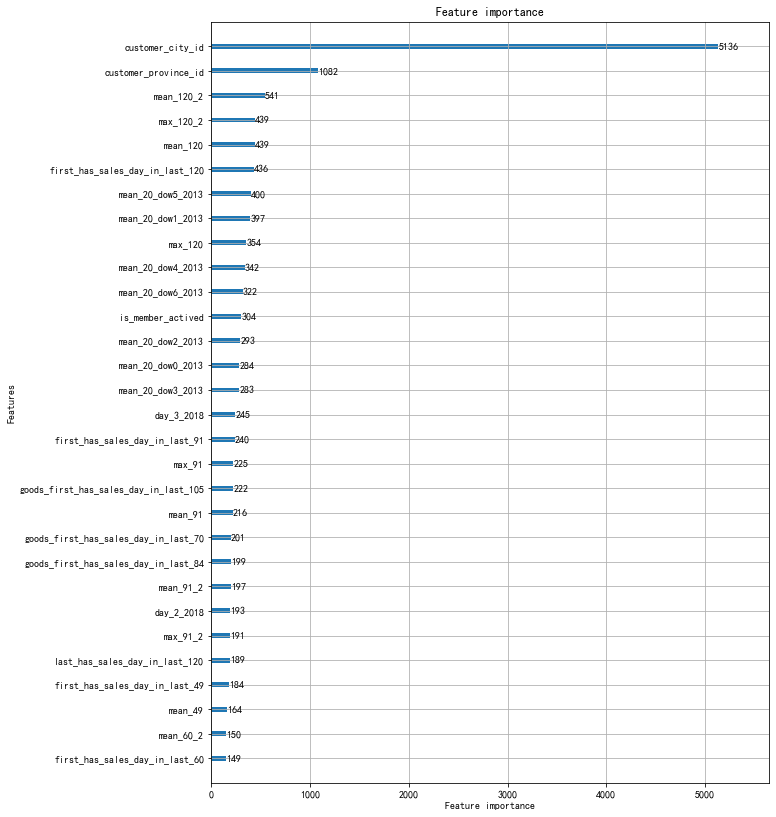

In [5]:
from lightgbm import plot_importance,plot_split_value_histogram

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax,max_num_features=30)
    
plot_features(bst, (10,14))

In [6]:
pd.DataFrame({'fea':X_total.columns, 'imp':bst.feature_importance()}).sort_values('imp',ascending = False)

,fea,imp
185,customer_city_id,5136
184,customer_province_id,1082
68,mean_120_2,541
70,max_120_2,439
61,mean_120,439
...,...,...
129,goods_median_49_2,0
133,goods_median_70,0
140,goods_median_70_2,0
144,goods_median_84,0


In [7]:
lgb_pred = bst.predict(
        X_total, num_iteration=bst.best_iteration or MAX_ROUNDS)

In [8]:
lgb_pred

array([0.17979651, 0.49042498, 0.2133033 , ..., 0.34017246, 0.40753006,
       0.74878439])

In [9]:
len(lgb_pred)

1585986

In [10]:
np.save("./lightgbm_pred.npy", lgb_pred)

In [11]:
lgb_pred = np.load("./lightgbm_pred.npy")

#### 因计算量太大（笔记本内存原因），本次不考虑XGBoost和Adaboost&DT方式

#### XGBoost全样本

In [ ]:
#XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb_classifier = xgb.fit(X_train_cv, y_train_cv)
# 模型在测试集上的预测
pred_xgb = xgb_classifier.predict(X_total)

#### Adaboost&DT全样本

In [ ]:
#Adaboost
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adb = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 20, min_samples_split = 10, 
                                                min_samples_leaf = 5),algorithm="SAMME",n_estimators=200,learning_rate=0.1)
X_train_cv.fillna(0)
#数据无穷处理
train_inf = np.isinf(X_train_cv)
X_train_cv[train_inf] = 0
adaboost_classifier = adb.fit(X_train_cv, y_train_cv)
# 模型在测试集上的预测
pred_adb = adaboost_classifier.predict(X_total)

#### 模型融合全样本

In [12]:
test_pred = (cat_pred + lgb_pred)/2

In [13]:
len(test_pred)

1585986

In [17]:
print("Preparing Predict dataset...")

print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
{    "customer_id": X_total.customer_id, 
    "result": y_test}
)
df_preds.head()

Preparing Predict dataset...
Making submission...


,customer_id,result
0,1000000,0.102123
1,1000014,0.556452
2,1000034,0.327030
3,1000046,0.226954
4,1000048,0.075449


In [16]:
train = pd.read_csv('./train.csv')
train[train.customer_id==1000014].head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
155115,1181340,1155016,1.0,129.9,66.9,0.0,2013-08-03 21:34:49,6,1.0,0.0,...,NaN,NaN,NaN,1038,1038,49.554744,1.0,0.0,2014-10-28 14:26:28,2014-11-04 14:26:28


In [22]:
submission = df_preds.copy()
submission['result'] = submission['result'].apply(lambda x : 1 if x > 0.5 else 0)

In [23]:
submission

,customer_id,result
0,1000000,0
1,1000014,1
2,1000034,0
3,1000046,0
4,1000048,0
...,...,...
1585981,2826570,1
1585982,2826571,0
1585983,2826572,0
1585984,2826573,0


In [25]:
submission.to_csv('./submission.csv',index=None)